# AutoInland Vehicle Insurance Claim Challenge 
_This is a notebook by Samson Tontoye._

# **Table of Contents**
1. [Problem Definition](#problem)\
2. [Read Data](#read)\
3. [EDA](#eda)\
    3.1 [Custom Color Palette](#color)\
    3.2 [Numeric Variables](#numeric)\
    3.3 [Categorical Variables](#categorical)
4. [Feature Engineering](#features)
5. [Modelling](#models)\
    5.1 [Logistic Regression](#logreg)\
    5.2 [Random Forest](#forest)\
    5.3 [KNeighborsClassifier](#neighbors)\
    5.4 [LightGBM](#lgbm)\
    5.5 [CatBoost](#catboost)\
    5.6 [XGBoost](#xgb)\   
6. [Conclusion](#conclusion)

## Introduction
This notebook looks into using various python-based machine learning and data science libraries in an attempt to develop a predictive machine learning model that determines if a customer will submit a vehicle insurance claim within next three months from their first transaction.

## What we'll end up with
Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.

To work through these topics, we'll use pandas, Matplotlib and NumPy for data anaylsis, as well as, Scikit-Learn for machine learning and modelling tasks.

We'll work through each step and by the end of the notebook, we'll have a handful of models, all which can predict whether or not a customer will claim insurance within the first three months using precision, recall and F1 score as the evaluation metric.

## **1. Problem Definition**

<a id="problem"></a>

This notebook is an insurance claim classification machine learning project with an imbalanced class.In this case, the problem we will be exploring is binary classification (a sample can only be one of two things).

This is because we are going to be using a number of different features (pieces of information) to predict if a customer will submit a vehicle insurance claim within next three months from their first transaction.

## 2. Data

The dataset came from Zindi in a formatted way [Zindi](https://zindi.africa/competitions/autoinland-vehicle-insurance-claim-challenge/data)

The data describes ~12,000 policies sold by AutoInland for car insurance. Information on the car type, make, customer age and start of policy are in the data.

## 3. Evaluation

The evaluation metric is something to define at the start of a project.

Since machine learning is very experimental:

           Since we are working with a highly imbalanced dataset, we will use the precision, recall and F1 score as an appropriate evaluation metric. If we can get a score of say 0.9 or over across this three evaluation metric at predicting whether or not a customer will submit a vehicle insurance claim within next three months from their first transaction during the proof of concept, we'll pursue this project.
           
## 4. Features

Features are different parts of the data. We're going to visualize the relationships between the different features of the data and how it can lead to a customer that will submit an insurance claim.

One of the most common ways to understand the features is to look at the **data dictionary**. For this project, the data dictionary is in the **Variable Definitions** csv file.

In [189]:
# Data Manipulation
import numpy as np
import pandas as pd
import scipy

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
import plotly.figure_factory as ff

# Feature Selection and Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# For the imbalanced dataset
from imblearn.over_sampling import SMOTE

# Random search
from sklearn.model_selection import RandomizedSearchCV 

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedShuffleSplit

# Manage warnings
import warnings
warnings.filterwarnings('ignore')

#For Datetime
import datetime as dt

from tqdm.notebook import tqdm_notebook
from collections import Counter

# Plot the figure inline
%matplotlib inline 

## **1. Read Data**

<a id="read"></a>

In [190]:
# Load the data into a pandas dataframe
train = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Train.csv')
test = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/Test.csv')
ss = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/SampleSubmission.csv')
var_def = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/VariableDefinitions.csv')
state_names = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/NigerianStateNames.csv')

## **2. Exploratory Data Analysis**

<a id="eda"></a>

**Cleaning**: To clean our data, we'll need to work with:

* **Missing values**: Either omit elements from a dataset that contain missing values or impute them (fill them in).
* **Special values**: Numeric variables are endowed with several formalized special values including ±Inf, NA and NaN. Calculations involving special values often result in special values, and need to be handled/cleaned.
* **Outliers**: They should be detected, but not necessarily removed. Their inclusion in the analysis is a statistical decision.
* **Obvious inconsistencies**: A person's age cannot be negative, a man cannot be pregnant and an under-aged person cannot possess a drivers license. Find the inconsistencies and plan for them.

When exploring our dataset and its features, we have many options available to us. We can explore each feature individually, or compare pairs of features, finding the correlation between. Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:

* Nominal: is for mutual exclusive, but not ordered, categories.
* Ordinal: is one where the order matters but not the difference between values.
* Interval: is a measurement where the difference between two values is meaningful.
* Ratio: has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:

* Numerical: any feature that contains numeric values.
* Categorical: any feature that contains categories, or text.

Since EDA has no real set methodology, the following is a short check list to to walk through:

1. From the dataframe features, what features are the highest indicator that the customer will claim insurance in the first 3 months?
2. What’s missing from the data and how do you deal with it?
3. Does gender play a role in a customer claiming insurance in the first 3 months?
4. Does policy start date play a role in a customer claiming insurance in the first 3 months?
5. Does policy end date/First transaction date play a role in a customer claiming insurance in the first 3 months?

In [191]:
# Top 5 rows of the train dataframe
train.head()

ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_0040R73        2010-05-14      2011-05-13    Male   30   
1  ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2  ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3  ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4  ID_00BRP63        2010-08-29      2010-12-31  Entity   20   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-05-14       1       Saloon              Black   
1             2010-11-29       1         JEEP               Grey   
2             2010-03-21       1       Saloon                Red   
3             2010-08-21       1          NaN                NaN   
4             2010-08-29       3          NaN                NaN   

  Subject_Car_Make LGA_Name  State  ProductName  target  
0           TOYOTA      NaN    NaN  Car Classic       0  
1           TOYOTA      NaN    NaN  Car Classic       1  
2           TOYOTA      NaN    NaN  Car Classic       0  
3              NaN      NaN    NaN      CarSafe       0  
4              NaN    Lagos  Lagos        Muuve       1

In [192]:
# Top 5 rows of the test dataframe
test.head()

ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_01QM0NU        2010-10-23      2011-10-22  Female   46   
1  ID_024NJLZ        2010-10-14      2011-10-13    Male   32   
2  ID_02NOVWQ        2010-08-29      2011-08-28  Female   45   
3  ID_02VSP68        2010-06-13      2011-06-12  Female   58   
4  ID_02YB37K        2010-07-01      2011-06-30     NaN  120   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-10-23       1          NaN                NaN   
1             2010-10-14       1          NaN                NaN   
2             2010-08-29       2       Saloon              Black   
3             2010-06-13       1       Saloon                NaN   
4             2010-07-01       1       Saloon                Red   

  Subject_Car_Make         LGA_Name            State  ProductName  
0             Ford  Abuja Municipal  Abuja-Municipal  Car Classic  
1              NaN           Kosofe            Benue  Car Classic  
2            Honda          Wuse 11            Abuja  Car Classic  
3           TOYOTA              NaN              NaN      CarSafe  
4          Hyundai  Victoria Island            Lagos  Car Classic

In [193]:
# Check the variable definition
var_def

ID  \
0           Policy Start Date   
1             Policy End Date   
2                      Gender   
3                         Age   
4                 ProductName   
5      First Transaction Date   
6                      No_Pol   
7                Car_Category   
8          Subject_Car_Colour   
9            Subject_Car_Make   
10                   LGA_Name   
11                      State   
12  No_of_claims_3_mon_period   

                           Unique ID for the customer  
0                                 Date policy started  
1                                   Date policy ended  
2                              Gender of the customer  
3                                 Age of the customer  
4                            Name of Insurance policy  
5                         First date payment was made  
6                 Number of policies the customer has  
7                                         Type of car  
8                                          Car colour  
9                                            Car make  
10                    City where policy was purchased  
11                   State where policy was purchased  
12  Wether the customer claimed within a 3 month p...

In [194]:
# Check the state names
state_names

LGA                         State
0           Abadam                   Borno State
1            Abaji     Federal Capital Territory
2             Abak               Akwa Ibom State
3        Abakaliki                  Ebonyi State
4        Aba-North                    Abia State
..             ...                           ...
870          Warri              Warri-South-West
871  Warri-Central                   Warri-South
872        Wuse-11  Abuja-Municipal-Area-Council
873           Yaba                Lagos-Mainland
874            NaN                       Unknown

[875 rows x 2 columns]

In [195]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
print('Length of the train dataset:', len(train))
print('Length of the test dataset:', len(test))
print('Total no of customers that will not claim insurance in the first 3 months:', len(train[train['target']==0]))
print('Total no of customers that will claim insurance in the first 3 months:', len(train[train['target']==1]))

Length of the train dataset: 12079
Length of the test dataset: 1202
Total no of customers that will not claim insurance in the first 3 months: 10624
Total no of customers that will claim insurance in the first 3 months: 1455


Since these two values(Customers that will claim insurance within the first 3 months and customers that will not claim insurance in the first 3 months) are not close, our target column can be considered **imbalanced**. An **imbalanced** target column, meaning some classes have far more samples, can be harder to model than a balanced set. From our target column, if the customer will claim insurance in the first 3 months, it is denoted with 1, if the customer will not claim insurance in the first 3 months, it is denoted as 0.

In [196]:
# To see the value in percentages
train['target'].value_counts(normalize=True)

0    0.879543
1    0.120457
Name: target, dtype: float64

The proportion of customer that will not claim insurance in the first 3 months to those that will claim insurance in the first 3 months is 7.3:1. 1 in 7 customers will claim insurance in the first 3 months.


In [197]:
# Check the shape of the train and test dataset
print(f'The shape of the train dataset is: {train.shape}\nThe shape of the test dataset is: {test.shape}')

The shape of the train dataset is: (12079, 14)
The shape of the test dataset is: (1202, 13)


In [198]:
# Check the information for the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


From the pandas train dataframe above,

* Age, No_Pol,and target are int datatype.
* The rest of the columns are object datatype.

In [199]:
# Check for missing values in the training dataset
train.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

In [200]:
# Check the information for the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1202 non-null   object
 1   Policy Start Date       1202 non-null   object
 2   Policy End Date         1202 non-null   object
 3   Gender                  1161 non-null   object
 4   Age                     1202 non-null   int64 
 5   First Transaction Date  1202 non-null   object
 6   No_Pol                  1202 non-null   int64 
 7   Car_Category            830 non-null    object
 8   Subject_Car_Colour      505 non-null    object
 9   Subject_Car_Make        954 non-null    object
 10  LGA_Name                546 non-null    object
 11  State                   546 non-null    object
 12  ProductName             1202 non-null   object
dtypes: int64(2), object(11)
memory usage: 122.2+ KB


From the pandas test dataframe above,

* Age and No_Pol are int datatype.
* The rest of the columns are object datatype.

In [201]:
# The .describe() function will demonstrate the count, mean, std dev, min, max, etc values for the 
# Numerical features present in the  train dataset.
train.describe()

Age        No_Pol        target
count  12079.000000  12079.000000  12079.000000
mean      42.234539      1.307227      0.120457
std       97.492565      0.733085      0.325509
min    -6099.000000      1.000000      0.000000
25%       35.000000      1.000000      0.000000
50%       41.000000      1.000000      0.000000
75%       50.000000      1.000000      0.000000
max      320.000000     10.000000      1.000000

In [202]:
# The .describe() function will demonstrate the count, mean, std dev, min, max, etc values for the 
# Numerical features present in the test dataset
test.describe()

Age       No_Pol
count  1202.000000  1202.000000
mean     43.792845     1.257903
std      19.986245     0.613510
min     -26.000000     1.000000
25%      35.000000     1.000000
50%      41.000000     1.000000
75%      50.000000     1.000000
max     120.000000     7.000000

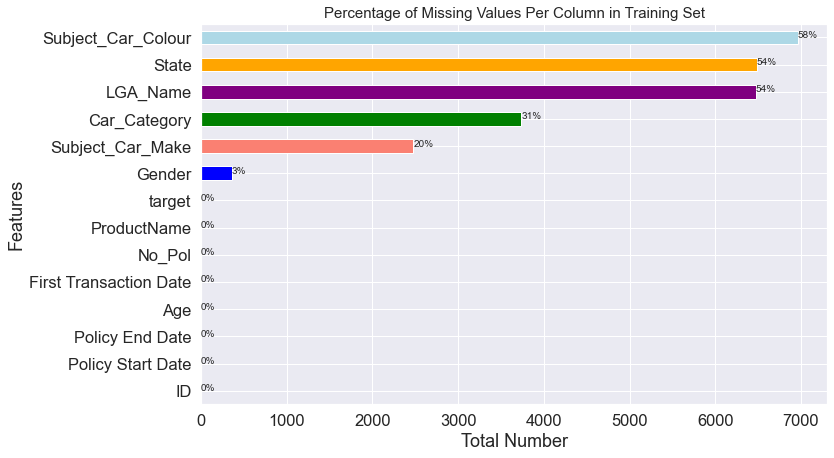

In [203]:
# Visualizing the missing values in the training dataset
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7),
                                           color=['indigo', 'yellow', 'brown', 'pink',
                                                 'cyan', 'gray', 'olive', 'orangered',
                                                 'blue', 'salmon', 'green', 'purple',
                                                 'orange','lightblue', 'red', 'violet'])

# Add some attributes
plt.title('Percentage of Missing Values Per Column in Training Set', fontdict={'size':15})
plt.xlabel('Total Number')
plt.ylabel('Features')

for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y));

In [204]:
# Check for missing values in the test dataset
test.isna().sum()

ID                          0
Policy Start Date           0
Policy End Date             0
Gender                     41
Age                         0
First Transaction Date      0
No_Pol                      0
Car_Category              372
Subject_Car_Colour        697
Subject_Car_Make          248
LGA_Name                  656
State                     656
ProductName                 0
dtype: int64

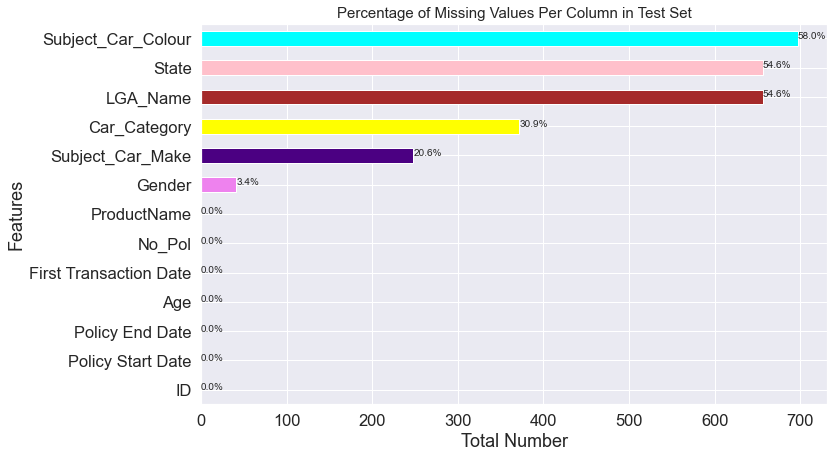

In [205]:
# Visualizing the missing values in the test dataset
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7),
                                          color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})
plt.xlabel('Total Number')
plt.ylabel('Features')

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine Train and Test Set for Easy Preprocessing 

In [206]:
# Combining the training and test dataset
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe
ntest=test.shape[0]

alldata = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {alldata.shape}')

The shape of the combined dataframe is: (13281, 14)


In [207]:
# Preview the bottom five rows of the combined dataframe
alldata.head()

ID Policy Start Date Policy End Date  Gender  Age  \
0  ID_0040R73        2010-05-14      2011-05-13    Male   30   
1  ID_0046BNK        2010-11-29      2011-11-28  Female   79   
2  ID_005QMC3        2010-03-21      2011-03-20    Male   43   
3  ID_0079OHW        2010-08-21      2011-08-20    Male    2   
4  ID_00BRP63        2010-08-29      2010-12-31  Entity   20   

  First Transaction Date  No_Pol Car_Category Subject_Car_Colour  \
0             2010-05-14       1       Saloon              Black   
1             2010-11-29       1         JEEP               Grey   
2             2010-03-21       1       Saloon                Red   
3             2010-08-21       1          NaN                NaN   
4             2010-08-29       3          NaN                NaN   

  Subject_Car_Make LGA_Name  State  ProductName  target  
0           TOYOTA      NaN    NaN  Car Classic     0.0  
1           TOYOTA      NaN    NaN  Car Classic     1.0  
2           TOYOTA      NaN    NaN  Car Classic     0.0  
3              NaN      NaN    NaN      CarSafe     0.0  
4              NaN    Lagos  Lagos        Muuve     1.0

In [208]:
# The .describe() function will demonstrate the count, mean, std dev, min, max, etc values for the 
# Numerical features present in the combined dataset
alldata.describe()

Age        No_Pol        target
count  13281.000000  13281.000000  12079.000000
mean      42.375574      1.302763      0.120457
std       93.170951      0.723195      0.325509
min    -6099.000000      1.000000      0.000000
25%       35.000000      1.000000      0.000000
50%       41.000000      1.000000      0.000000
75%       50.000000      1.000000      0.000000
max      320.000000     10.000000      1.000000

<p style="text-align:center;">Investigate numeric variables- age, No_Pol</p>

<p style="text-align:center;">Histograms for each, their effect on the target.</p>

<p style="text-align:center;">Potentially graph their effects</p>

### 3.1 Create Custom Color Palette

<a id="color"></a>

Text(-0.5, -0.7, 'Color Palette For This Notebook')

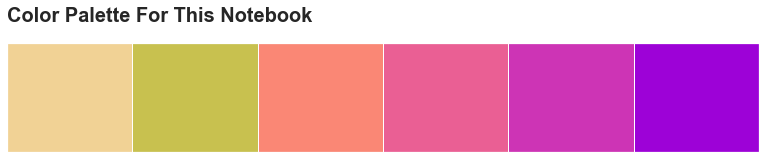

In [209]:
# Create the different shades of colors for the color pallete
colors = ["#f1d295", "#c8c14f", "#fa8775", "#ea5f94", "#cd34b5", "#9d02d7"]
palette = sns.color_palette(palette = colors)

sns.palplot(palette, size = 2)
plt.text(-0.5, -0.7, 'Color Palette For This Notebook', size = 20, weight = 'bold')

### 3.2 Numeric Variables

<a id="numeric"></a>

<p style="text-align:center;"><b>Age Distribution of Customers.</b></p>

Text(0, 0.5, 'Count')

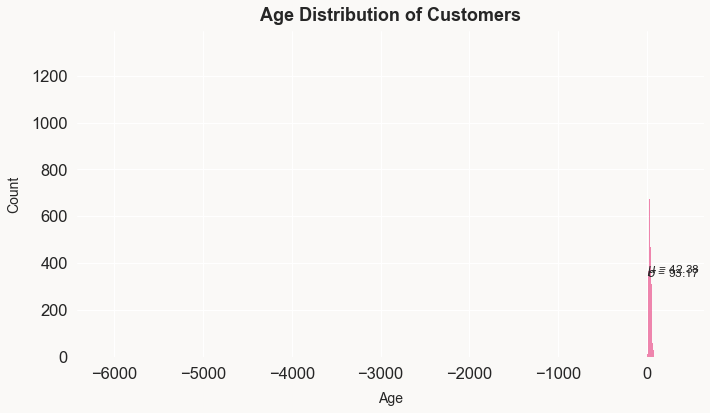

In [210]:
# Plot the histogram for the age distribution of customers
fig, ax = plt.subplots(figsize = (10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

sns.histplot(
    alldata['Age'],
    kde = False,
    color = "#ea5f94"
)

for i in ['top', 'left', 'bottom', 'right']:
    ax.spines[i].set_visible(False)

plt.text(5, 360, r'$\mu$ = '+str(round(alldata['Age'].mean(), 2)), fontsize = 12)
plt.text(5, 343, r'$\sigma$ = '+str(round(alldata['Age'].std(), 2)), fontsize = 12)
plt.title('Age Distribution of Customers', fontsize = 18, fontweight = 'bold', pad = 10)
plt.xlabel('Age', fontsize = 14, labelpad = 10)
plt.ylabel('Count', fontsize = 14, labelpad = 10)

### Check for Outliers in Age

<AxesSubplot:ylabel='Age'>

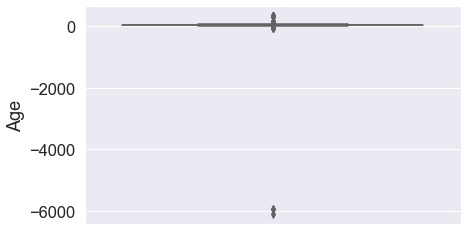

In [211]:
# Plot a boxplot of the age of the customers showing the spread and IQR before removing outliers
sns.boxplot(y = 'Age', data = alldata ,palette='Accent')

In [212]:
# Visualize the age distribution of the customers before removing outliers
Age = list(alldata['Age'].values)
hist_data=[Age]

group_labels=['Age']
colour=['Red']

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, colors=colour)
fig.show()
print('The shape before removing the Age outliers :', alldata.shape)

The shape before removing the Age outliers : (13281, 14)


In [214]:
# Visualize the age distribution of the customers after removing outliers
Age=list(alldata['Age'].values)
hist_data=[Age]

group_lables=['Age']
colour=['Red']

fig=ff.create_distplot(hist_data,group_lables,show_hist=True,colors=colour)
fig.show()

alldata.drop(alldata[alldata['Age'] < 0].index, inplace = True)
alldata.drop(alldata[alldata['Age'] > 93].index, inplace = True)
print("The shape after removing the Age outliers : ",alldata.shape)

The shape after removing the Age outliers :  (12847, 14)


In [215]:
# Visualize the spread of the age distribution of the customers after removing outliers
alldata_Age = alldata.groupby('Age', as_index=False)['target'].sum()
fig = px.histogram(alldata_Age, 
                   x = "Age",
                   y = "target", 
                   barmode = "group", 
                   nbins = 10, 
                   opacity = 0.75, 
                   range_x = [0,85],
                   color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_layout(height = 500, 
                  width = 700, 
                  title_text ='Age Distribution of Customers After Removing Outliers',
                  title_font_size= 20,
                  title_y = 0.97,
                  title_x = 0.48,
                  yaxis_title = 'Count')

fig.show()

<AxesSubplot:ylabel='Age'>

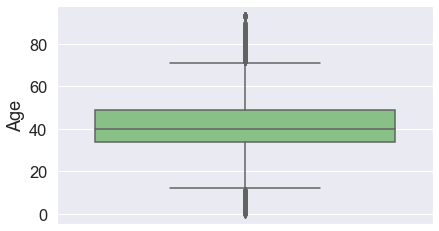

In [216]:
# Plot a boxplot of the age of the customers showing the spread and IQR after removing outliers
sns.boxplot(y = 'Age', data = alldata ,palette='Accent')

**Observation**:

After removing the outliers, the range is now between 0 and 90 which is where most of the age samples are distributed. 

<p style="text-align:center;"><b>Frequency of Number of Policies.</b></p>

Text(0, 0.5, 'Count')

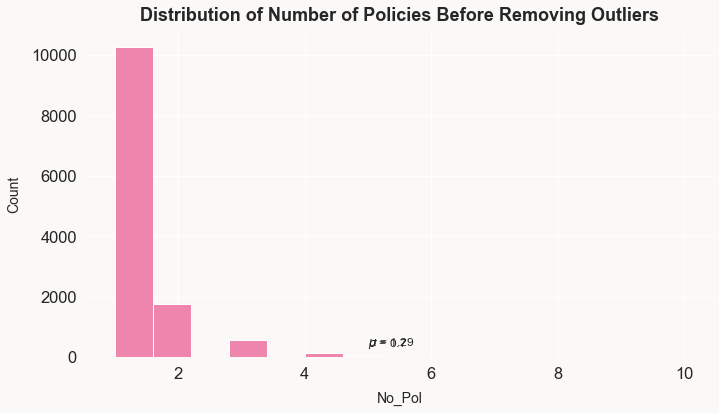

In [217]:
fig, ax = plt.subplots(figsize = (10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

sns.histplot(
    alldata['No_Pol'],
    kde = False,
    color = "#ea5f94"
)

for i in ['top', 'left', 'bottom', 'right']:
    ax.spines[i].set_visible(False)

plt.text(5, 360, r'$\mu$ = '+str(round(alldata['No_Pol'].mean(), 2)), fontsize = 12)
plt.text(5, 343, r'$\sigma$ = '+str(round(alldata['No_Pol'].std(), 2)), fontsize = 12)
plt.title('Distribution of Number of Policies Before Removing Outliers', fontsize = 18, fontweight = 'bold', pad = 10)
plt.xlabel('No_Pol', fontsize = 14, labelpad = 10)
plt.ylabel('Count', fontsize = 14, labelpad = 10)

### Remove the Outliers in Number of Policies

<AxesSubplot:ylabel='No_Pol'>

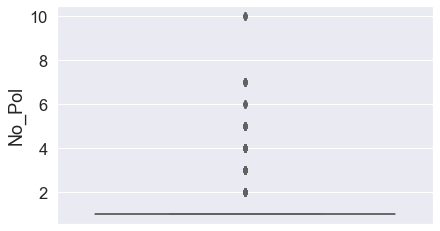

In [218]:
# Plot a boxplot of the number of policies of the customers showing the spread and IQR before removing outliers
sns.boxplot(y = 'No_Pol', data = alldata ,palette='Accent')

In [219]:
No_Pol = list(alldata['No_Pol'].values)
hist_data=[No_Pol]

group_labels=['No_Pol']
colour=['Red']

fig = ff.create_distplot(hist_data, group_labels, show_hist=True, colors=colour)
fig.show()
print('The Shape Before Removing the Number of Policies Outliers :', alldata.shape)

The Shape Before Removing the Number of Policies Outliers : (12847, 14)


In [221]:
No_Pol=list(alldata['No_Pol'].values)
hist_data=[No_Pol]

group_lables=['No_Pol']
colour=['Red']

fig=ff.create_distplot(hist_data, group_lables, show_hist=True, colors=colour)
fig.show()

alldata.drop(alldata[alldata['No_Pol'] > 3].index, inplace = True)
print("The Shape After Removing the Age Outliers : ",alldata.shape)

The Shape After Removing the Age Outliers :  (12640, 14)


<AxesSubplot:ylabel='No_Pol'>

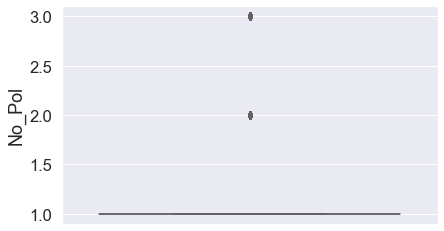

In [222]:
# Plot a boxplot of the number of policies of the customers showing the spread and IQR after removing outliers
sns.boxplot(y = 'No_Pol', data = alldata ,palette='Accent')

Text(0, 0.5, 'Count')

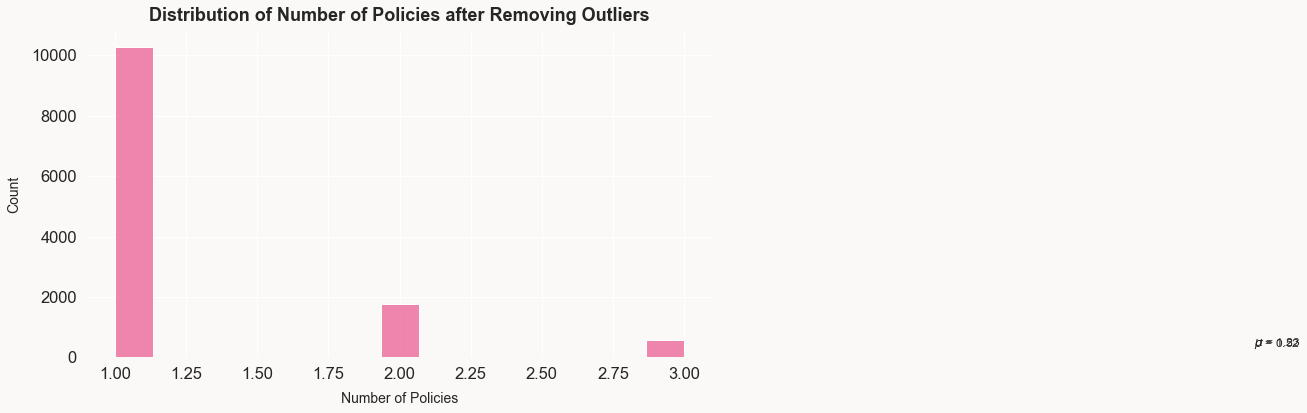

In [223]:
fig, ax = plt.subplots(figsize = (10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

sns.histplot(
    alldata['No_Pol'],
    kde = False,
    color = "#ea5f94"
)

for i in ['top', 'left', 'bottom', 'right']:
    ax.spines[i].set_visible(False)

plt.text(5, 360, r'$\mu$ = '+str(round(alldata['No_Pol'].mean(), 2)), fontsize = 12)
plt.text(5, 343, r'$\sigma$ = '+str(round(alldata['No_Pol'].std(), 2)), fontsize = 12)
plt.title('Distribution of Number of Policies after Removing Outliers', fontsize = 18, fontweight = 'bold', pad = 10)
alldata.drop(alldata[alldata['No_Pol'] > 3].index, inplace = True)
plt.xlabel('Number of Policies', fontsize = 14, labelpad = 10)
plt.ylabel('Count', fontsize = 14, labelpad = 10)

**Observation**:

After removing the outliers, the range is now between 1 and 3 which is where most of the number of policies samples are distributed. 

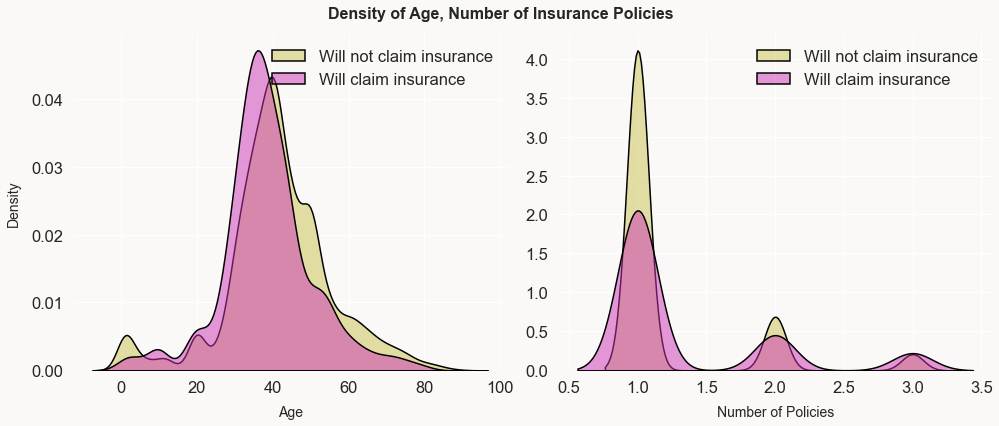

In [224]:
# Plot the density plot of the Age and Number of Policies of Insurance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
fig.patch.set_facecolor('#faf9f7')

for i in (ax1, ax2):
    i.set_facecolor('#faf9f7')
    
sns.kdeplot(
    alldata['Age'][alldata['target'] == 0],
    ax = ax1,
    color = '#c8c14f',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

sns.kdeplot(
    alldata['Age'][alldata['target'] == 1],
    ax = ax1,
    color = '#cd34b5',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

ax1.legend(['Will not claim insurance', 'Will claim insurance'], loc = 'upper right')
ax1.set_xlabel('Age', fontsize = 14, labelpad = 10)
ax1.set_ylabel('Density', fontsize = 14, labelpad = 10)

sns.kdeplot(
    alldata['No_Pol'][alldata['target'] == 0],
    ax = ax2,
    color = '#c8c14f',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

sns.kdeplot(
    alldata['No_Pol'][alldata['target'] == 1],
    ax = ax2,
    color = '#cd34b5',
    shade = True,
    alpha = 0.5,
    linewidth = 1.5,
    ec = 'black'
)

ax2.legend(['Will not claim insurance', 'Will claim insurance'], loc='upper right')
ax2.set_xlabel('Number of Policies', fontsize = 14, labelpad = 10)
ax2.set_ylabel('')

plt.suptitle('Density of Age, Number of Insurance Policies', fontsize = 16, fontweight = 'bold')

for i in (ax1, ax2):
    for j in ['top', 'left', 'bottom', 'right']:
        i.spines[j].set_visible(False)

fig.tight_layout()


<p style="text-align:center;"><b>Scatter plots of numerical variables colored by insurance.</b></p>

In [225]:
# Assign the target column to a variable
will_claim_insurance = alldata[alldata['target'] == 1]
will_not_claim_insurance = alldata[alldata['target'] == 0]

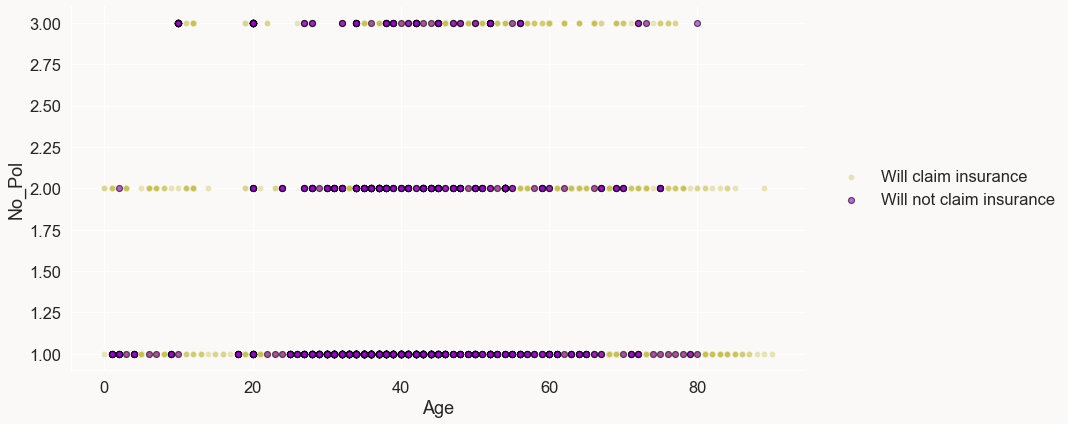

In [226]:
# Plot a scatter plot of the number of insurance policies against age
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.patch.set_facecolor('#faf9f7')
for j in range(0, 1):
    ax.set_facecolor('#faf9f7')

## Age vs Number of Policies
sns.scatterplot(
    data = will_not_claim_insurance, x = 'Age', y = 'No_Pol', color = '#c8c14f',
    alpha = 0.4, ax = ax
)
sns.scatterplot(
    data = will_claim_insurance, x = 'Age', y = 'No_Pol', color = "#9d02d7",
    ax = ax, edgecolor = 'black', linewidth = 1.2, alpha = 0.6
)
    
sns.despine()

for i in range(0, 1):
    ax.legend(['Will claim insurance', 'Will not claim insurance'], loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
    

fig.tight_layout()

### 3.3 Categorical Variables

<a id="categorical"></a>

<p style="text-align:center;"><b>Let's first investigate the target variable.</b></p>

In [227]:
# Check the proportion of classes of the target column
alldata['target'].value_counts(normalize = True)

0.0    0.882747
1.0    0.117253
Name: target, dtype: float64

Text(0.5, 1.0, 'Percentage of Target')

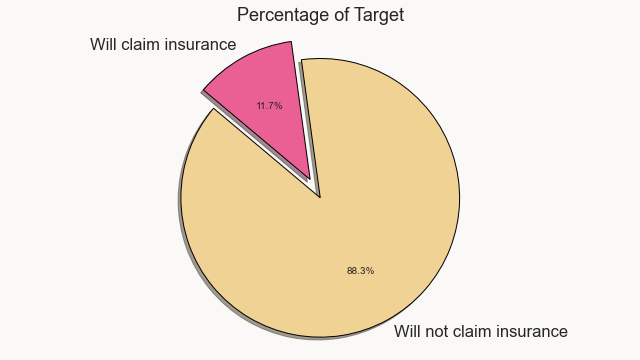

In [228]:
# Plot a pie chart of the target column showing the proportion
fig, ax = plt.subplots(figsize = (10, 6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

labels = ['Will not claim insurance', 'Will claim insurance']
colors = ['#f1d295', '#ea5f94']
sizes = alldata['target'].value_counts()

plt.pie(sizes, explode = [0, 0.15], labels = labels, colors = colors,
           autopct = '%1.1f%%', shadow = True, startangle = 140,
           wedgeprops = {'ec': 'black'}, textprops = {'fontweight': 'medium'}
)

plt.axis('equal')
plt.title('Percentage of Target')

<p style="text-align:center;"><b>Gender</b></p>

In [229]:
# Check the number of genders
alldata.Gender.value_counts()

Male            8084
Female          3600
Joint Gender     236
Entity           223
NOT STATED       188
NO GENDER         68
SEX               41
Name: Gender, dtype: int64

In [230]:
# Replace gender that is not male or female with other
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
alldata.Gender = alldata.Gender.replace(mapper)

# Confirm mappings
alldata.Gender.value_counts()

Male      8084
Female    3600
Other      756
Name: Gender, dtype: int64

In [231]:
# Replace the other with nan
alldata['Gender'] = alldata['Gender'].replace({'Other': np.nan})
alldata['Gender']

0          Male
1        Female
2          Male
3          Male
4           NaN
          ...  
13276      Male
13277      Male
13278      Male
13279      Male
13280      Male
Name: Gender, Length: 12640, dtype: object

In [232]:
# Drop cases where either variable is missing
data = alldata[['Gender', 'target']].dropna() 
pd.crosstab(data.Gender, data.target)

target   0.0  1.0
Gender           
Female  2905  348
Male    6499  861

Text(0.5, 1.0, 'Percentage of Gender')

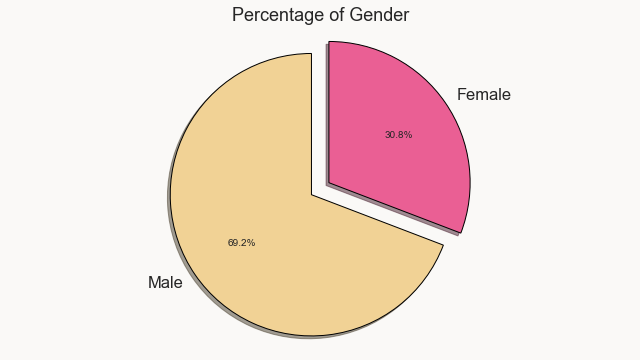

In [233]:
# Plot a pie chart of the gender column showing the proportion of male to female
fig, ax = plt.subplots(figsize = (10, 6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

labels = ['Male', 'Female']
colors = ['#f1d295', '#ea5f94']
sizes = alldata['Gender'].value_counts()

plt.pie(sizes, explode = [0, 0.15], labels = labels, colors = colors,
           autopct = '%1.1f%%', shadow = True, startangle = 90,
           wedgeprops = {'ec': 'black'}, textprops = {'fontweight': 'medium'}
)

plt.axis('equal')
plt.title('Percentage of Gender')

Text(0.5, 50.0, 'target')

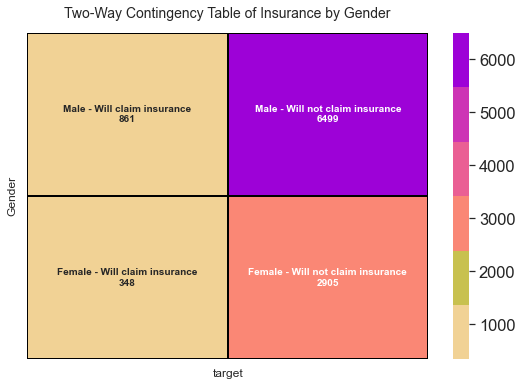

In [234]:
# plot a two way contingency table of insurance by gender
plt.subplots(figsize=(8,6))

insurance_matrix = np.array([[861, 6499], [348, 2905]])
labels = np.array([['Male - Will claim insurance', 'Male - Will not claim insurance'], 
                   ['Female - Will claim insurance', 'Female - Will not claim insurance']])
formatted = (np.asarray(["{0}\n{1:.0f}".format(text, data) for text, data in zip(labels.flatten(), insurance_matrix.flatten())])).reshape(2,2)


sns.heatmap(
    insurance_matrix,
    annot = formatted,
    fmt = '',
    cmap = palette,
    xticklabels = False,
    yticklabels = False,
    linecolor = 'black',
    linewidth = 1,
    annot_kws = {'fontweight': 'semibold'}
)
plt.title('Two-Way Contingency Table of Insurance by Gender', pad = 15, fontsize = 14)
plt.ylabel('Gender', fontsize = 12, labelpad = 10)
plt.xlabel('target', fontsize = 12, labelpad = 10)

**Observation**:

Since there are 3253 women, 2905 women will not claim insurance and 348 of them will claim insurance, we might infer, based on this one variable if the customer is a woman, there's a 10.7% chance the female customer will claim insurance.

As for males, there are 7360 males, 6499 men will not claim insurance and 861 of them will claim insurance. So we might predict, if the customer is male, there is a 11.7% chance he will claim insurance.

Averaging these two values, we can assume, based on no other parameters, if there's a person, there's a 11.2% chance they will claim insurance.

<p style="text-align:center;"><b>Car Category</b></p>

In [235]:
# Check the proportion of each car in the car category
alldata.Car_Category.value_counts(normalize=True)

Saloon                     0.731337
JEEP                       0.238261
Truck                      0.009796
Mini Bus                   0.004954
Bus                        0.004729
Pick Up                    0.003040
Motorcycle                 0.001802
Sedan                      0.001576
Mini Van                   0.001239
Wagon                      0.001126
Station 4 Wheel            0.000676
Shape Of Vehicle Chasis    0.000676
Van                        0.000338
Pick Up > 3 Tons           0.000225
CAMRY CAR HIRE             0.000113
Tipper Truck               0.000113
Name: Car_Category, dtype: float64

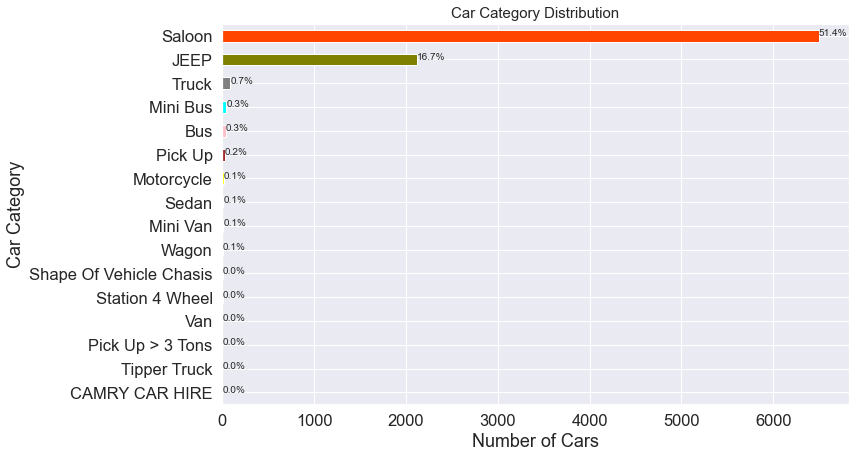

In [236]:
# Car_category Distribution before Joining
ax = alldata.Car_Category.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(10, 7), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Car Category Distribution', fontdict={'size': 15})
plt.xlabel('Number of Cars')
plt.ylabel('Car Category')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

In [237]:
# Replace car category that is not saloon or jeep with others
mapper = {'Truck':'Others', 'Mini Bus':'Others', 'Bus':'Others', 'Pick Up': 'Others', 'Sedan':"Others", 'Motorcycle': 'Others', 
          'Mini Van':'Others', 'Wagon': 'Others', 'Shape Of Vehicle Chasis': 'Others', 'Station 4 Wheel': 'Others', 'Van': 'Others',
          'Pick Up > 3 Tons': 'Others', 'CAMRY CAR HIRE': 'Others', 'Tipper Truck': 'Others'}
alldata.Car_Category = alldata.Car_Category.replace(mapper)

# Confirm mappings
alldata.Car_Category.value_counts()

Saloon    6495
JEEP      2116
Others     270
Name: Car_Category, dtype: int64

Text(0.5, 1.0, 'Percentage of Car Category')

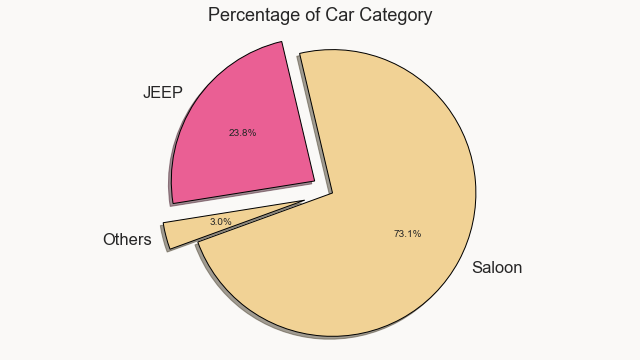

In [238]:
# Plot a pie chart of the car category column showing the proportion after joining
fig, ax = plt.subplots(figsize = (10, 6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

labels = ['Saloon', 'JEEP', 'Others']
colors = ['#f1d295', '#ea5f94']
sizes = alldata['Car_Category'].value_counts()

plt.pie(sizes, explode = [0, 0.15, 0.2], labels = labels, colors = colors,
           autopct = '%1.1f%%', shadow = True, startangle = 200,
           wedgeprops = {'ec': 'black'}, textprops = {'fontweight': 'medium'}
)

plt.axis('equal')
plt.title('Percentage of Car Category')

**Observation:**

73.1% of the vehicles insured by AutoInland insurance are saloon cars, 23.8% of vehicles insured are jeeps and 3% of vehicles insured have been grouped as others.

In [239]:
# Compare the target column to car_category
pd.crosstab(alldata.Car_Category, alldata.target)

target         0.0  1.0
Car_Category           
JEEP          1684  234
Others         189   56
Saloon        5099  803

#### Frequency of Car Category

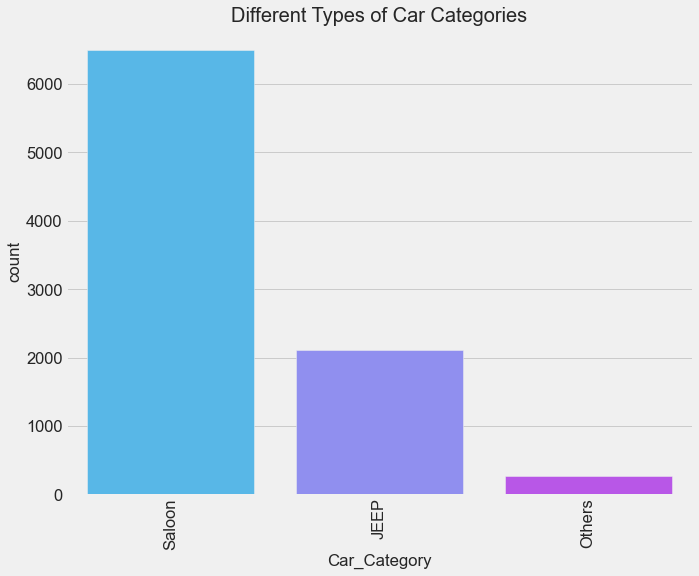

In [240]:
# let's check the car categories

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)

sns.countplot(alldata['Car_Category'], palette = 'cool')
plt.title('Different Types of Car Categories', fontsize = 20)
plt.xticks(rotation = 90)
plt.show() 

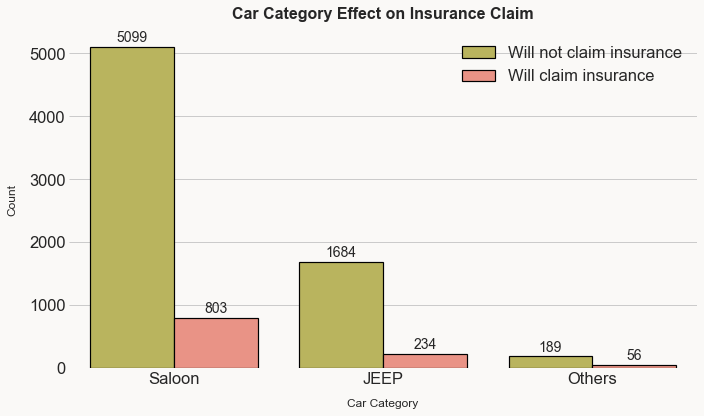

In [241]:
# Barchart of the different car categories and check the number that claimed insurance and those that did not 
# claim insurance after joining.
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = alldata, x = 'Car_Category', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Car Category Effect on Insurance Claim", size = 16, weight = 'bold', pad = 12)
plt.xlabel('Car Category', size = 12, labelpad = 12)
plt.ylabel('Count', size = 12, labelpad = 12)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

<p style="text-align:center;"><b>Subject Car Make</b></p>

In [242]:
# Check the proportion of subject car make
alldata.Subject_Car_Make.value_counts(normalize=True)

TOYOTA      0.528081
Honda       0.110021
Lexus       0.062469
Mercedes    0.051657
Hyundai     0.046551
              ...   
Jincheng    0.000100
Hummer      0.000100
Datsun      0.000100
Raston      0.000100
Tata        0.000100
Name: Subject_Car_Make, Length: 74, dtype: float64

In [243]:
# Compare the target column to subject car make
pd.crosstab(alldata.Subject_Car_Make, alldata.target)

target            0.0  1.0
Subject_Car_Make          
.                  21    6
ABG                 1    0
ACURA              57    7
As Attached         4    0
Ashok Leyland       1    0
...               ...  ...
Volkswagen        111    4
Volvo              29    8
Wrangler Jeep       1    0
Yamaha              1    0
ZOYTE               1    0

[73 rows x 2 columns]

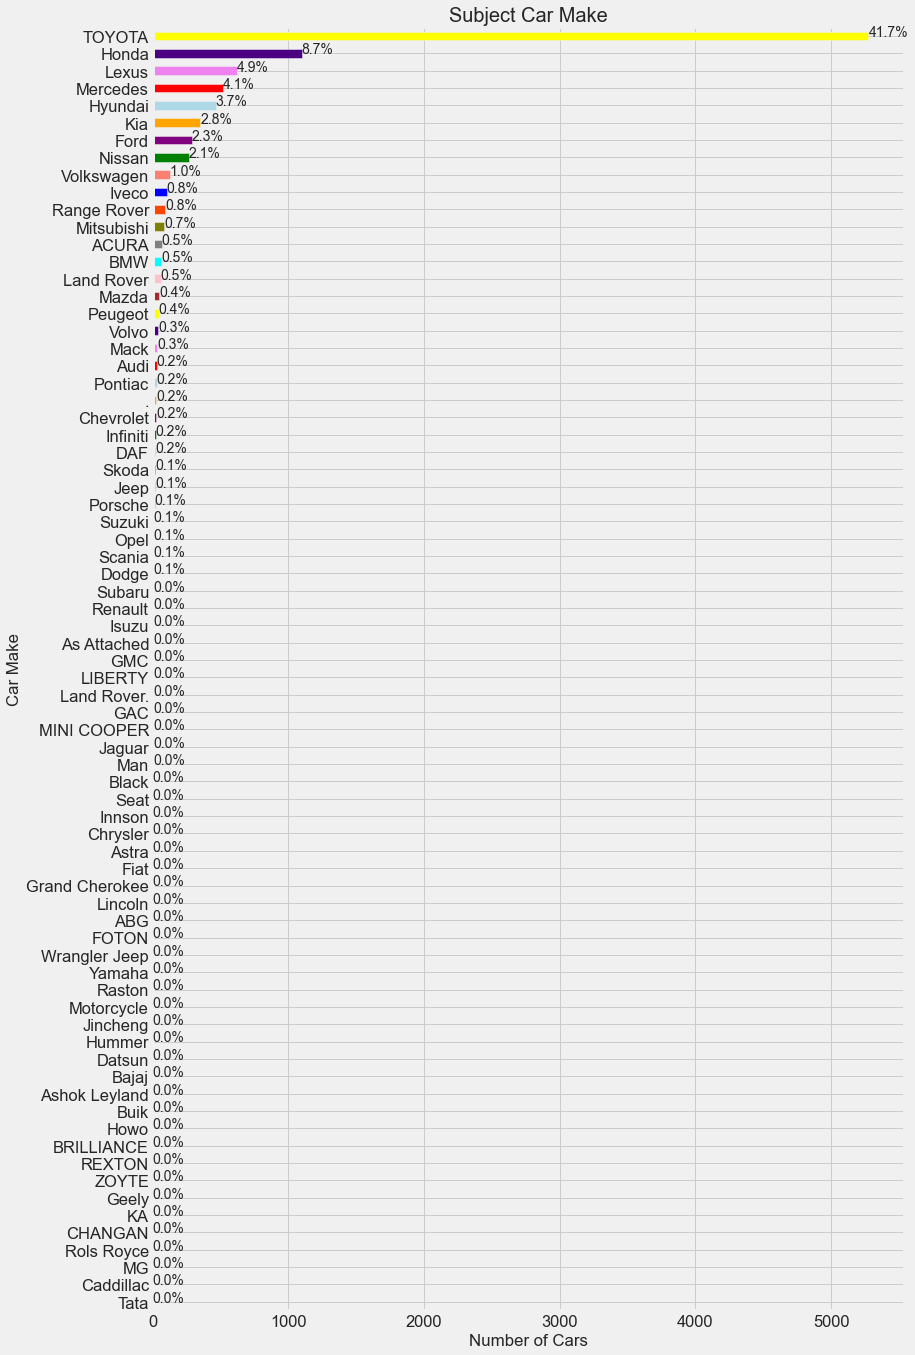

In [244]:
# Subject car make Distribution before joining
ax = alldata.Subject_Car_Make.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(12, 22), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Subject Car Make', fontdict={'size': 20})
plt.xlabel('Number of Cars')
plt.ylabel('Car Make')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

In [245]:
# Replace subject car make that are less than 200 with others
mapper = {'Range Rover':'Others', 'Mitsubishi':'Others', 'ACURA':'Others', 'BMW': 'Others', 'Land Rover':"Others", 'Mazda': 'Others', 
          'Peugeot':'Others', '.': 'Others', 'Volvo': 'Others', 'Mack': 'Others', 'Audi': 'Others','Infiniti': 'Others', 
          'Pontiac': 'Others', 'Chevrolet': 'Others', 'DAF': 'Others', 'Skoda': 'Others', 'Jeep': 'Others', 
          'Porsche': 'Others', 'As Attached': 'Others', 'Scania':'Others', 'Suzuki':'Others', 'Opel':'Others', 
          'Isuzu': 'Others', 'Dodge':"Others", 'Renault': 'Others', 'Land Rover.':'Others', 'Subaru':'Others', 'GMC':'Others', 
          'GAC': 'Others', 'Man':"Others", 'LIBERTY': 'Others', 'MINI COOPER': 'Others', 'Jaguar': 'Others', 'Wrangler Jeep': 'Others',
          'Hummer': 'Others', 'Chrysler': 'Others', 'Fiat': 'Others', 'Grand Cherokee': 'Others', 'Astra': 'Others', 'Innson':'Others',
          'Seat': 'Others', 'Black': 'Others', 'FOTON':'Others', 'Datsun': 'Others', 'Geely':'Others', 'Yamaha': 'Others', 'ABG': 'Others',
          'REXTON': 'Others', 'ZOYTE': 'Others', 'CHANGAN':'Others', 'BRILLIANCE': 'Others', 'Motorcycle': 'Others', 'Raston':'Others',
          'COMMANDER':'Others', 'Jincheng':'Others', 'Caddillac':'Others', 'Buik':'Others', 'Rols Royce':'Others', 'KA': 'Others',
          'Howo': 'Others', 'Lincoln':'Others', 'Tata':'Others', 'Ashok Leyland':'Others', 'MG':'Others', 'Bajaj':'Others',
          'Volkswagen':'Others', 'Iveco': 'Others'}
alldata.Subject_Car_Make = alldata.Subject_Car_Make.replace(mapper)

# Confirm mappings
alldata.Subject_Car_Make.value_counts(normalize=True)

TOYOTA      0.528081
Others      0.110421
Honda       0.110021
Lexus       0.062469
Mercedes    0.051657
Hyundai     0.046551
Kia         0.035339
Ford        0.028832
Nissan      0.026629
Name: Subject_Car_Make, dtype: float64

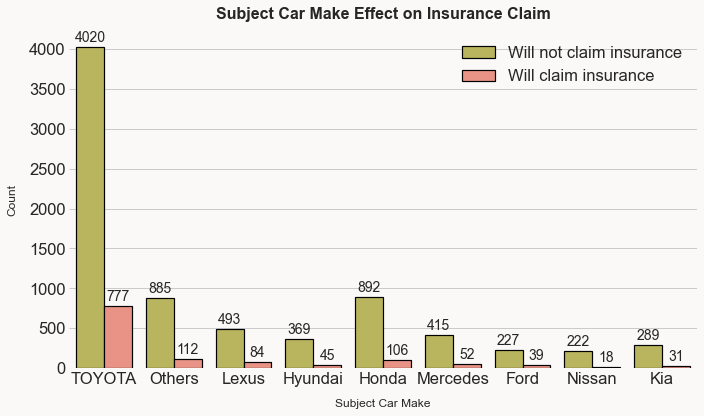

In [246]:
# Plot a barchart of the different car make and check the number that claimed 
# insurance and those that did not claim insurance after joining.
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = alldata, x = 'Subject_Car_Make', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Subject Car Make Effect on Insurance Claim", size = 16, weight = 'bold', pad = 12)
plt.xlabel('Subject Car Make', size = 12, labelpad = 12)
plt.ylabel('Count', size = 12, labelpad = 12)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

<p style="text-align:center;"><b>STATE</b></p>

In [247]:
# Check the proportion of state
alldata.State.value_counts(normalize=True)

Lagos              0.537281
Benue              0.122766
Abuja-Municipal    0.043690
Eti-Osa            0.042968
Ibeju-Lekki        0.022567
                     ...   
Ovia-SouthWest     0.000181
Ogba-Ndoni         0.000181
Asari-Toru         0.000181
Bayelsa            0.000181
Kebbi              0.000181
Name: State, Length: 113, dtype: float64

In [248]:
# Compare the target column to State
pd.crosstab(alldata.State, alldata.target)

target         0.0  1.0
State                  
ABULE-EGBA       5    1
AJAO-ESTATE      2    0
Aba-North        3    0
Aba-South        1    0
Abia             2    0
...            ...  ...
Ughelli-North    1    0
Umuahia-South    2    0
Warri-Central   23    4
Warri-North      3    0
Warri-South      2    0

[111 rows x 2 columns]

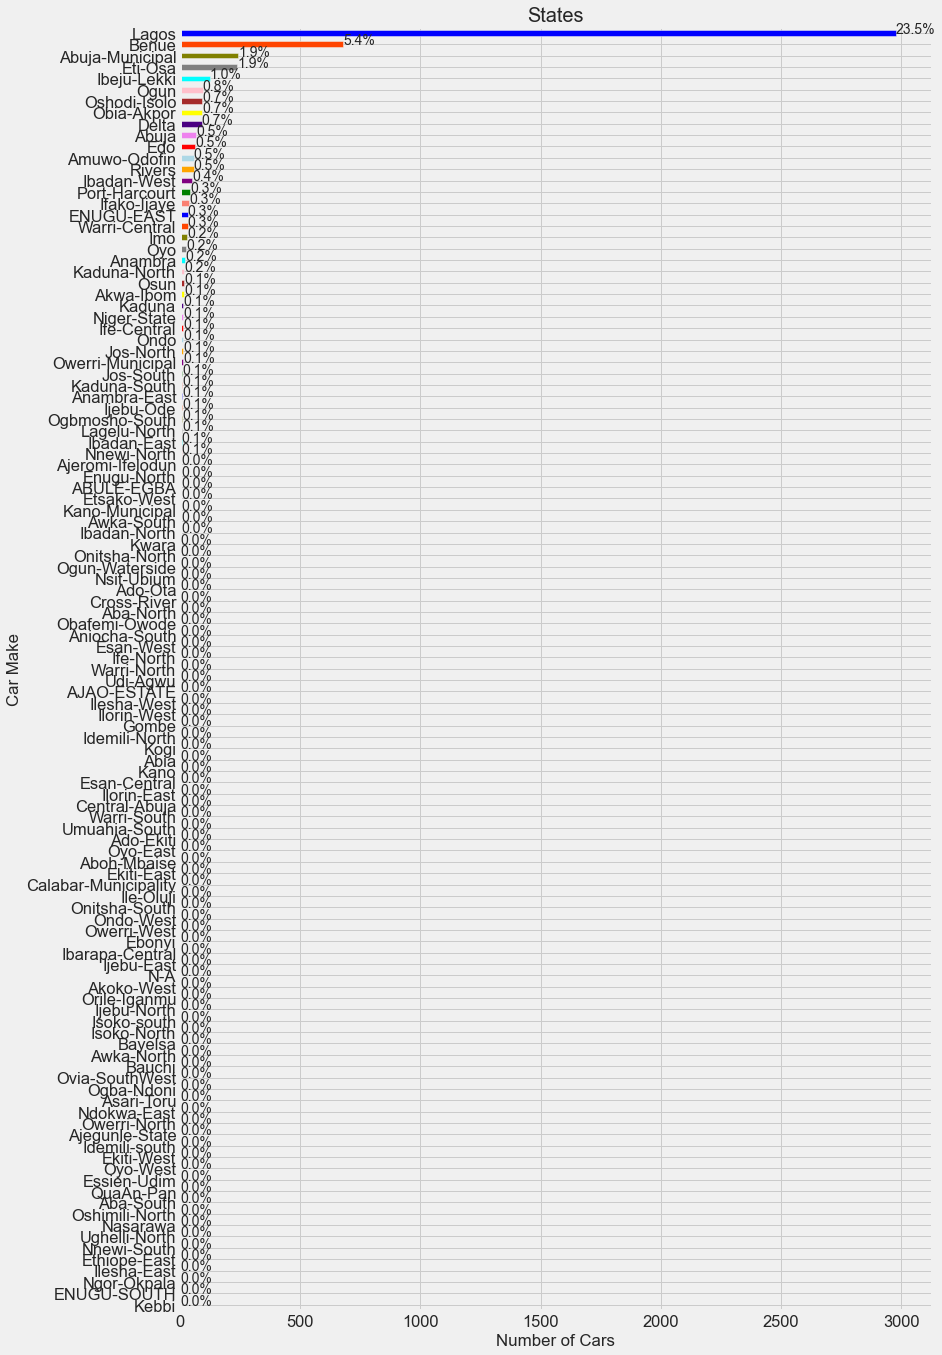

In [249]:
# State Distribution before joining
ax = alldata.State.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(12, 22), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('States', fontdict={'size': 20})
plt.xlabel('Number of Cars')
plt.ylabel('Car Make')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

In [250]:
# Replace local governments that are in each states with the actual states
mapper = {'Abuja-Municipal':'Abuja', 'Eti-Osa':'Lagos', 'Ibeju-Lekki':'Lagos', 'Obia-Akpor': 'Rivers', 'Oshodi-Isolo':"Lagos", 'Amuwo-Odofin': 'Lagos', 
          'Ibadan-West':'Oyo', 'Port-Harcourt': 'Rivers', 'Ifako-Ijaye': 'Lagos', 'ENUGU-EAST': 'Enugu', 'Warri-Central': 'Delta','Kaduna-North': 'Kaduna', 
          'Ife-Central': 'Osun', 'Jos-North': 'Plateau', 'Owerri-Municipal': 'Imo', 'Ijebu-Ode': 'Ogun', 'Jos-South': 'Plateau', 
          'Kaduna-South': 'Kaduna', 'Anambra-East': 'Anambra', 'Enugu-North':'Enugu', 'Lagelu-North':'Oyo', 'Ogbmosho-South':'Oyo', 
          'Ibadan-East': 'Oyo', 'Nnewi-North':"Anambra", 'Ibadan-North': 'Oyo', 'Etsako-West':'Edo', 'Ajeromi-Ifelodun':'Lagos', 'ABULE-EGBA':'Lagos', 
          'Kano-Municipal': 'Kano', 'Awka-South':"Anambra", 'Obafemi-Owode': 'Ogun', 'Ilesha-West': 'Osun', 'Nsit-Ubium': 'Akwa-Ibom', 'Aba-North': 'Abia',
          'Aniocha-South': 'Delta', 'Onitsha-North': 'Anambra', 'Ado-Ota': 'Ogun', 'Ogun-Waterside': 'Ogun', 'Esan-West': 'Edo', 'Ife-North':'Osun',
          'Warri-North': 'Delta', 'Ilorin-West': 'Kwara', 'Udi-Agwu':'Enugu', 'AJAO-ESTATE': 'Lagos', 'Onitsha-South':'Anambra', 'Orile-Iganmu': 'Lagos', 'Esan-Central': 'Edo',
          'Ondo-West': 'Ondo', 'Ilorin-East': 'Kwara', 'Idemili-North':'Anambra', 'Ekiti-East': 'Ekiti', 'Warri-South': 'Delta', 'Oyo-East':'Oyo',
          'Aboh-Mbaise':'Imo', 'Ado-Ekiti':'Ekiti', 'Central-Abuja':'Abuja', 'Ibarapa-Central':'Oyo', 'Ile-Oluji':'Ondo', 'Owerri-West': 'Imo',
          'Calabar-Municipality': 'Cross-River', 'Umuahia-South':'Abia', 'QuaAn-Pan':'Plateau', 'Ogba-Ndoni':'Rivers', 'Awka-North':'Anambra', 'Aba-South':'Abia',
          'Ekiti-West':'Ekiti', 'Ughelli-North': 'Delta', 'Isoko-North': 'Delta', 'Asari-Toru': 'Rivers', 'Ndokwa-East':'Delta', 'Idemili-south':'Anambra', 'Ethiope-East':'Delta', 
          'Oyo-West': 'Oyo', 'Oshimili-North':"Delta", 'Ngor-Okpala': 'Imo', 'Ilesha-East':'Osun', 'Nnewi-South':'Anambra', 'Essien-Udim':'Akwa-Ibom', 
          'Owerri-North': 'Imo', 'Ajegunle-State':"Lagos", 'Isoko-south': 'Delta', 'Akoko-West': 'Ondo', 'Ijebu-East': 'Ogun', 'ENUGU-SOUTH': 'Enugu',
          'Ijebu-North': 'Ogun', 'N-A': 'Kano', 'Ovia-SouthWest': 'Edo', 'Akwa Ibom': 'Akwa-Ibom', 'Cross River': 'Cross-River', 'Cross Rivers': 'Cross-River'}
alldata.State = alldata.State.replace(mapper)

# Confirm mappings
alldata.State.value_counts()

Lagos          3544
Benue           680
Abuja           312
Rivers          196
Delta           138
Ogun            119
Oyo             113
Edo              77
Anambra          56
Imo              50
Kaduna           44
Enugu            43
Osun             39
Plateau          24
Akwa-Ibom        23
Ondo             19
Niger-State      14
Abia              9
Kwara             9
Kano              8
Cross-River       6
Ekiti             5
Gombe             3
Ebonyi            2
Kogi              2
Bayelsa           1
Bauchi            1
Nasarawa          1
Kebbi             1
Name: State, dtype: int64

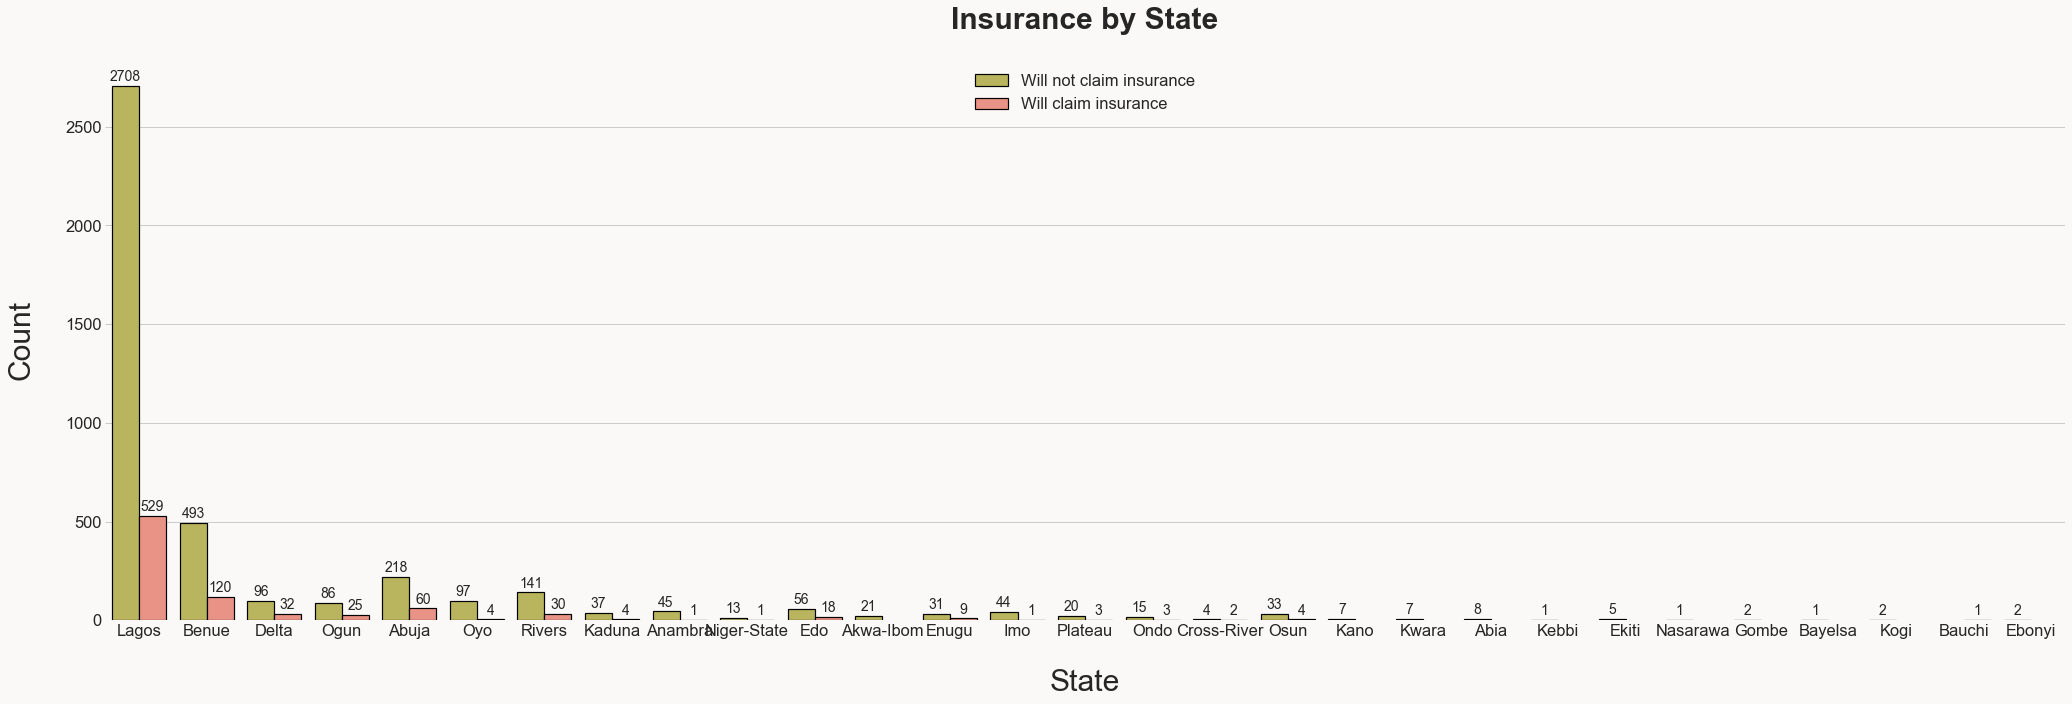

In [251]:
# Plot a barchart of the different states and check the number that claimed 
# insurance and those that did not claim insurance after joining.
fig, ax = plt.subplots(figsize=(29,10))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = alldata, x = 'State', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Insurance by State", size = 30, weight = 'bold', pad = 30)
plt.xlabel('State', size = 30, labelpad = 30)
plt.ylabel('Count', size = 30, labelpad = 30)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

<p style="text-align:center;"><b>LGA NAMES</b></p>

In [252]:
alldata.LGA_Name.value_counts()

Victoria Island    891
Ikeja              421
Surulere           298
Abuja Municipal    242
Lagos Mainland     239
                  ... 
Bauchi               1
Ekwusigo             1
Nwangele             1
Essien Udim          1
EFFURUN              1
Name: LGA_Name, Length: 270, dtype: int64

In [253]:
# Compare the target column to State
pd.crosstab(alldata.LGA_Name, alldata.target)

target       0.0  1.0
LGA_Name             
 IFAKO         1    1
ABULE EGBA     5    1
AJAO ESTATE    2    0
AKOKO-EDO      1    0
AKUTE          2    3
...          ...  ...
Yaba          31    2
Yenagoa        1    0
Yorro          1    0
Zaria          2    0
kumbotso       1    0

[258 rows x 2 columns]

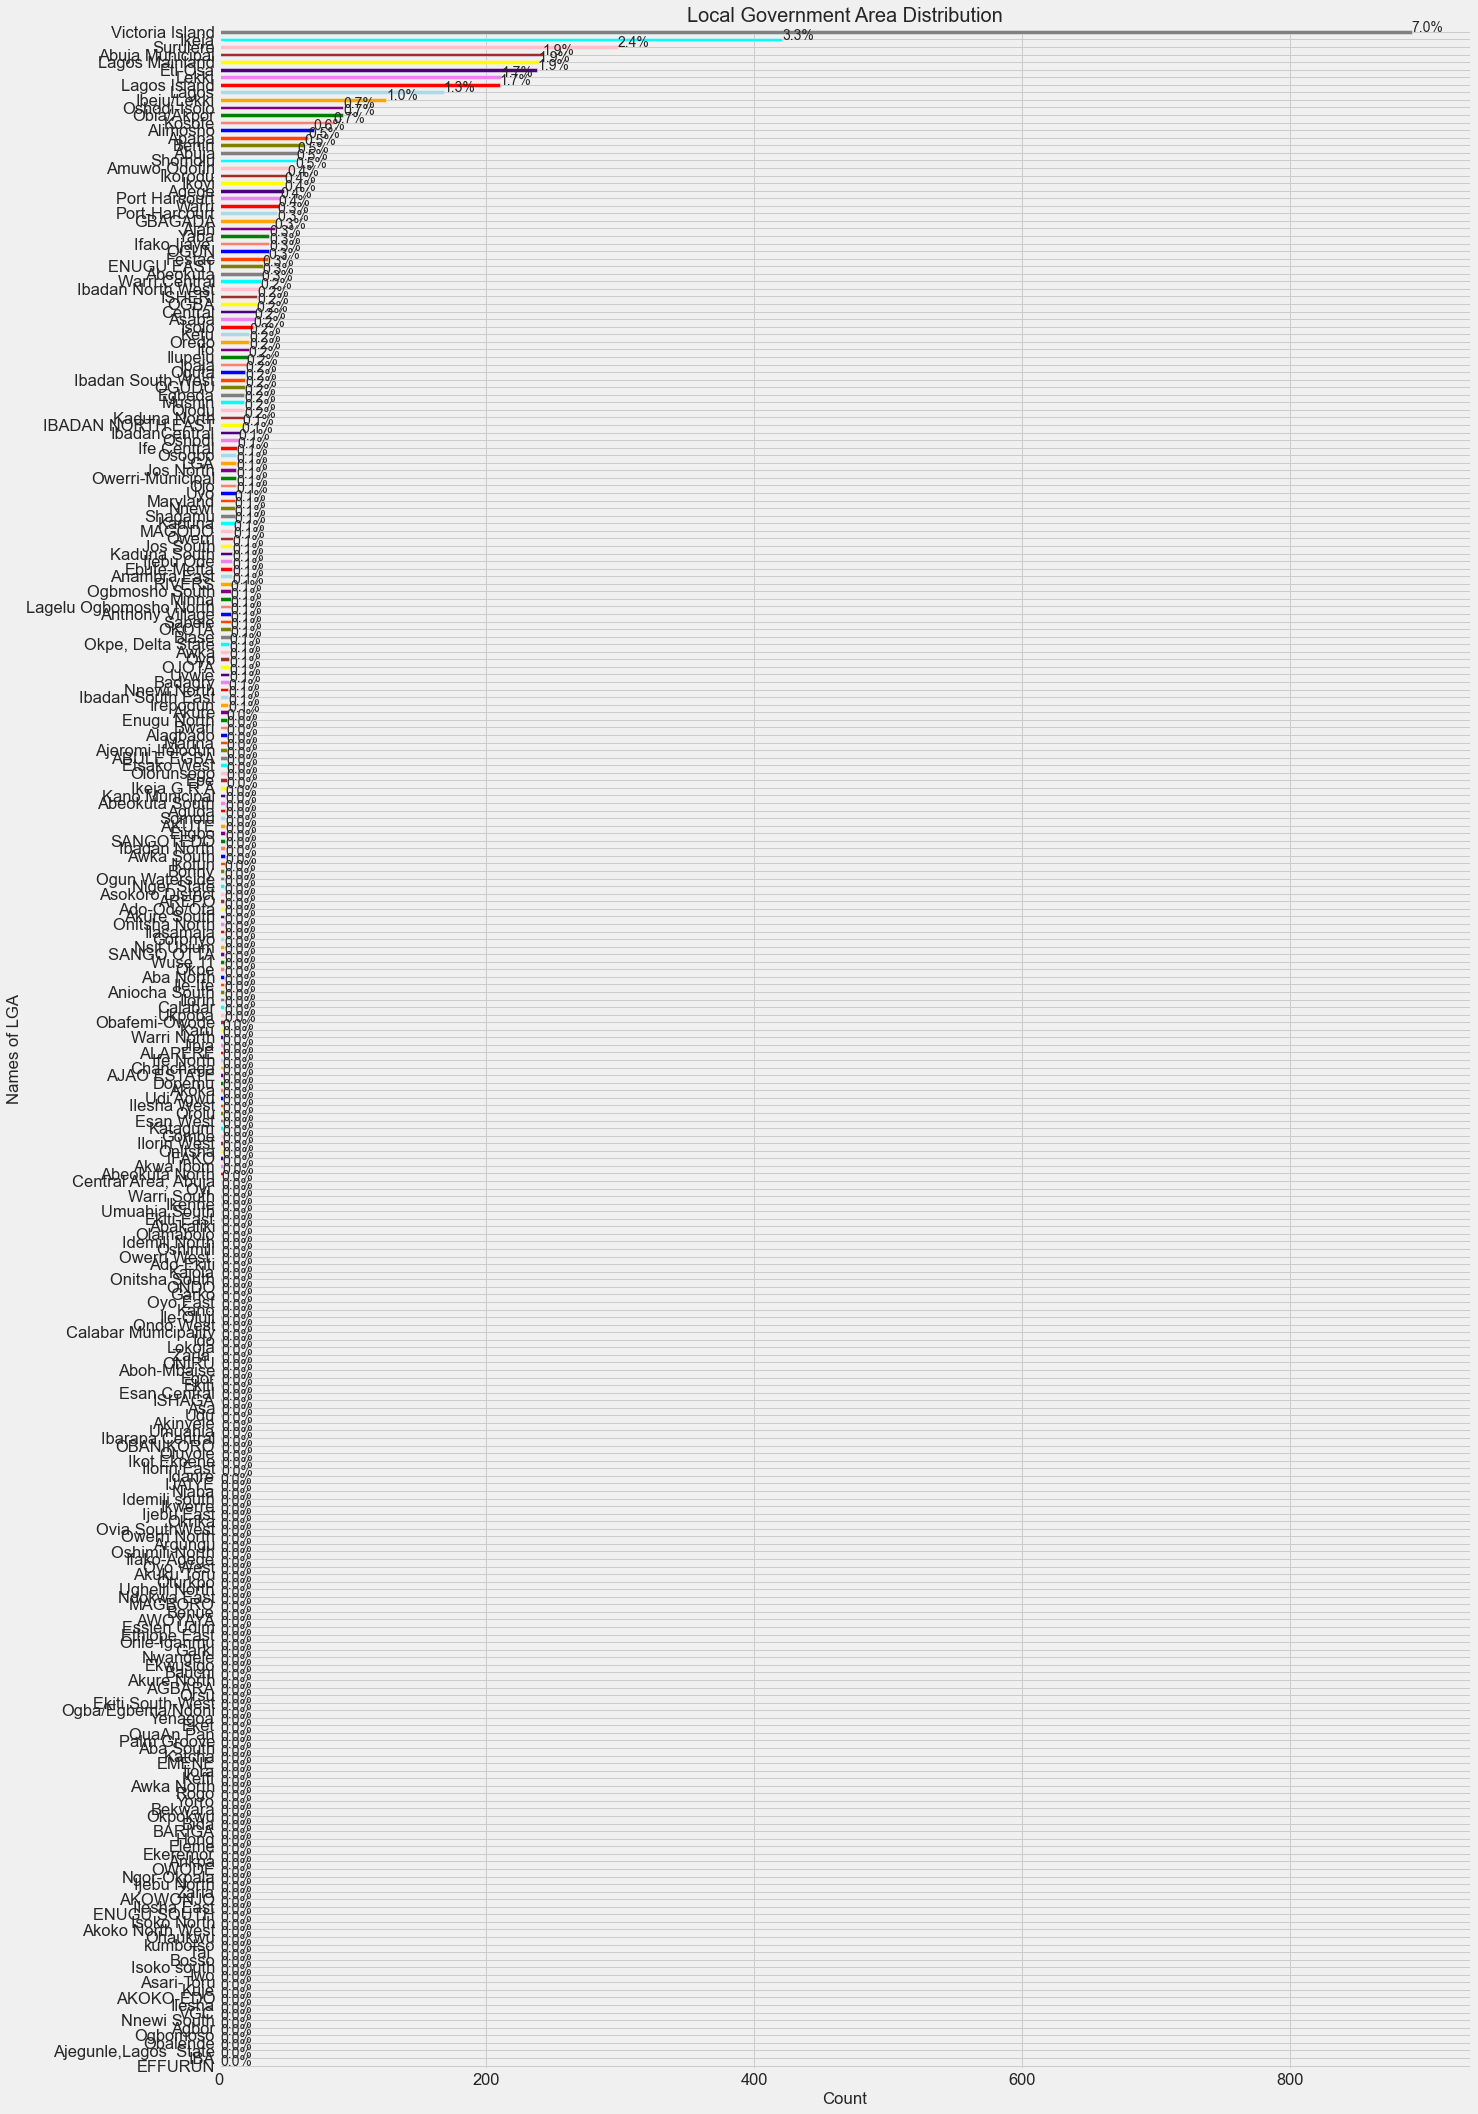

In [254]:
# LGA Names Distribution
ax = alldata.LGA_Name.value_counts().sort_values().plot(kind='barh', 
                                                            figsize=(20, 35), 
                                                            color=['blue', 'salmon', 'green', 'purple',
                                                                  'orange','lightblue', 'red', 'violet',
                                                                  'indigo', 'yellow', 'brown', 'pink',
                                                                  'cyan', 'gray', 'olive', 'orangered'])

# Add some attributes
plt.title('Local Government Area Distribution', fontdict={'size': 20})
plt.xlabel('Count')
plt.ylabel('Names of LGA')

for p in ax.patches:
    percentage = '{:,.1f}%'.format((p.get_width()/alldata.shape[0]) * 100)
    width, height = p.get_width(), p.get_height()
    x = p.get_x() + width + 0.02
    y = p.get_y() + height/2
    ax.annotate(percentage,(x, y));

<p style="text-align:center;"><b>Product Name</b></p>

In [255]:
alldata.ProductName.value_counts()

Car Classic         6889
CarSafe             4113
Car Plus             513
Customized Motor     471
CVTP                 382
CarFlex              193
Motor Cycle           39
Muuve                 35
Car Vintage            5
Name: ProductName, dtype: int64

In [256]:
# Compare the target column to State
pd.crosstab(alldata.ProductName, alldata.target)

target             0.0   1.0
ProductName                 
CVTP               265    89
Car Classic       5203  1049
Car Plus           375   101
Car Vintage          5     0
CarFlex            146    29
CarSafe           3721    14
Customized Motor   388    31
Motor Cycle         31     6
Muuve                7    28

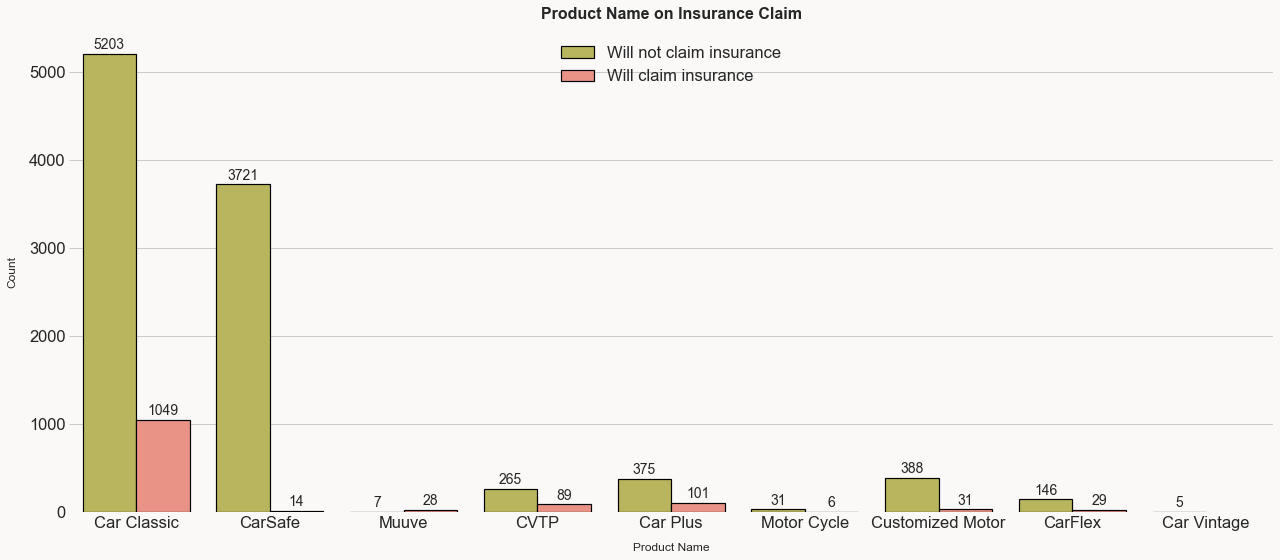

In [257]:
# Plot a barchart of the different product name and check the number that claimed 
# insurance and those that did not claim insurance.
fig, ax = plt.subplots(figsize=(18,8))
fig.patch.set_facecolor('#faf9f7')
ax.set_facecolor('#faf9f7')

bar_pal = ["#c8c14f", "#fa8775"]

s = sns.countplot(
    data = alldata, x = 'ProductName', hue = 'target', palette = bar_pal,
    linewidth = 1.2, ec = 'black'
)

for i in ['top', 'right', 'bottom', 'left']:
    ax.spines[i].set_visible(False)

plt.legend(['Will not claim insurance', 'Will claim insurance'])
plt.title("Product Name on Insurance Claim", size = 16, weight = 'bold', pad = 12)
plt.xlabel('Product Name', size = 12, labelpad = 12)
plt.ylabel('Count', size = 12, labelpad = 12)

for i in s.patches:
    s.annotate(format(i.get_height(), '.0f'),  (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

fig.tight_layout()

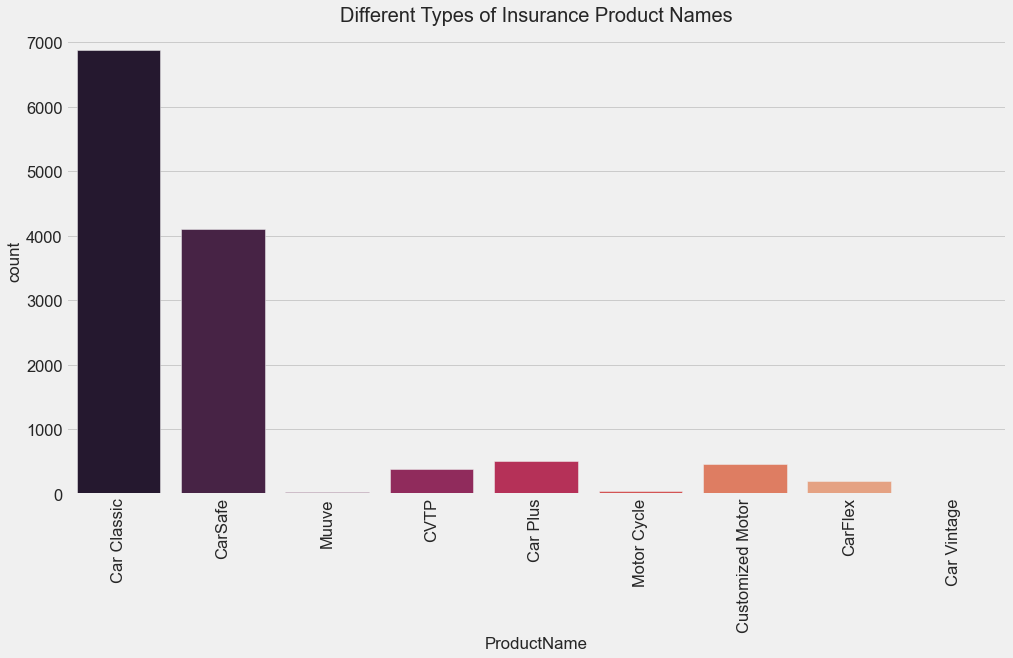

In [258]:
# let's visualize the different product names

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

sns.countplot(alldata['ProductName'], palette = 'rocket')
plt.title('Different Types of Insurance Product Names', fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [259]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
print('Length of the concatenated dataset:', len(alldata))
print('Total no of customers that will not claim insurance in the first 3 months:', len(alldata[alldata['target']==0]))
print('Total no of customers that will claim insurance in the first 3 months:', len(alldata[alldata['target']==1]))

Length of the concatenated dataset: 12640
Total no of customers that will not claim insurance in the first 3 months: 10141
Total no of customers that will claim insurance in the first 3 months: 1347


In [260]:
# Check the shape of the concatenated dataset
print(f'The shape of the concatenated dataset is: {alldata.shape}')

The shape of the concatenated dataset is: (12640, 14)


In [261]:
# Check the proportion of the classes in the target column
alldata['target'].value_counts(normalize=True)

0.0    0.882747
1.0    0.117253
Name: target, dtype: float64

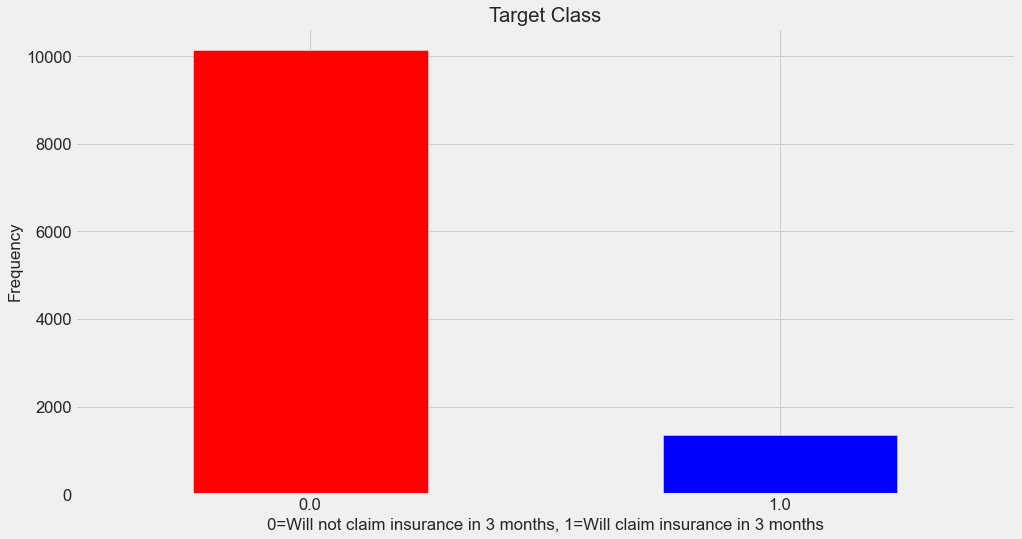

In [262]:
# Plot the target value counts with a bar graph
alldata.target.value_counts().plot(kind='bar', title = 'Target Class', color=['red', 'blue'])
plt.xlabel('0=Will not claim insurance in 3 months, 1=Will claim insurance in 3 months')
plt.ylabel('Frequency')
plt.xticks(rotation=0);

In [263]:
# Check if there are any missing values
alldata.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     956
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3759
Subject_Car_Colour        7367
Subject_Car_Make          2651
LGA_Name                  7089
State                     7101
ProductName                  0
target                    1152
dtype: int64

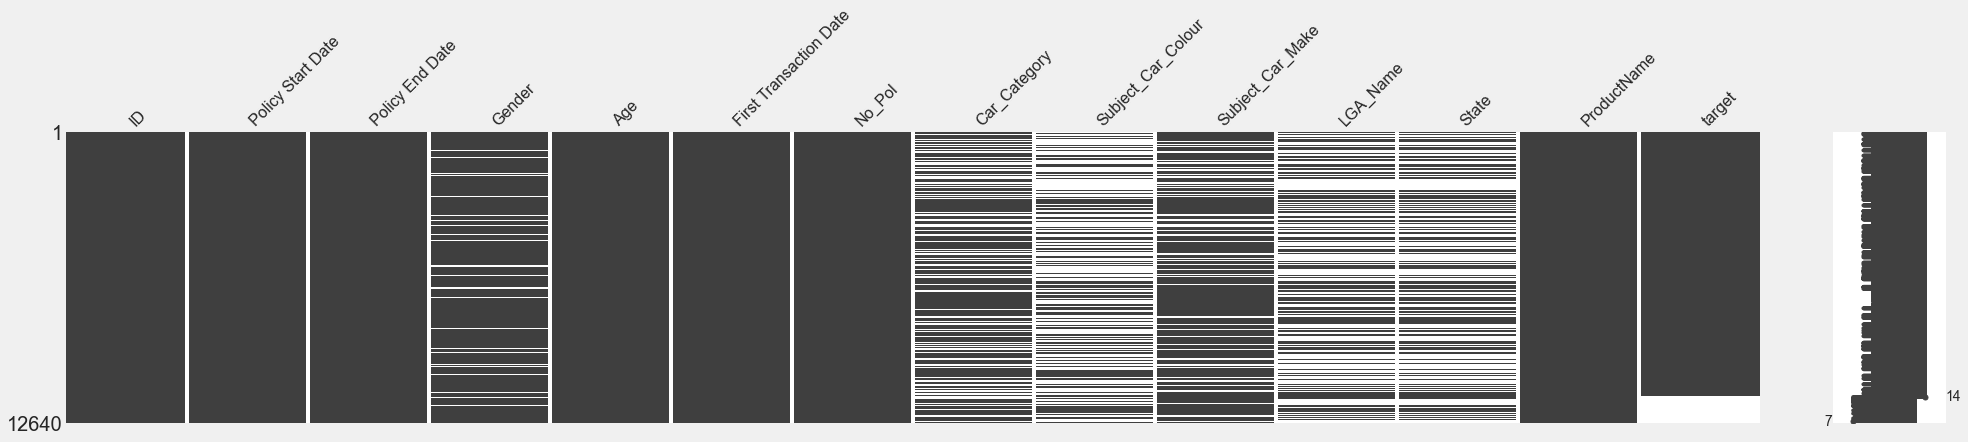

In [264]:
# Visualizing the missing values in the dataset
missingno.matrix(alldata, figsize=(30, 5));

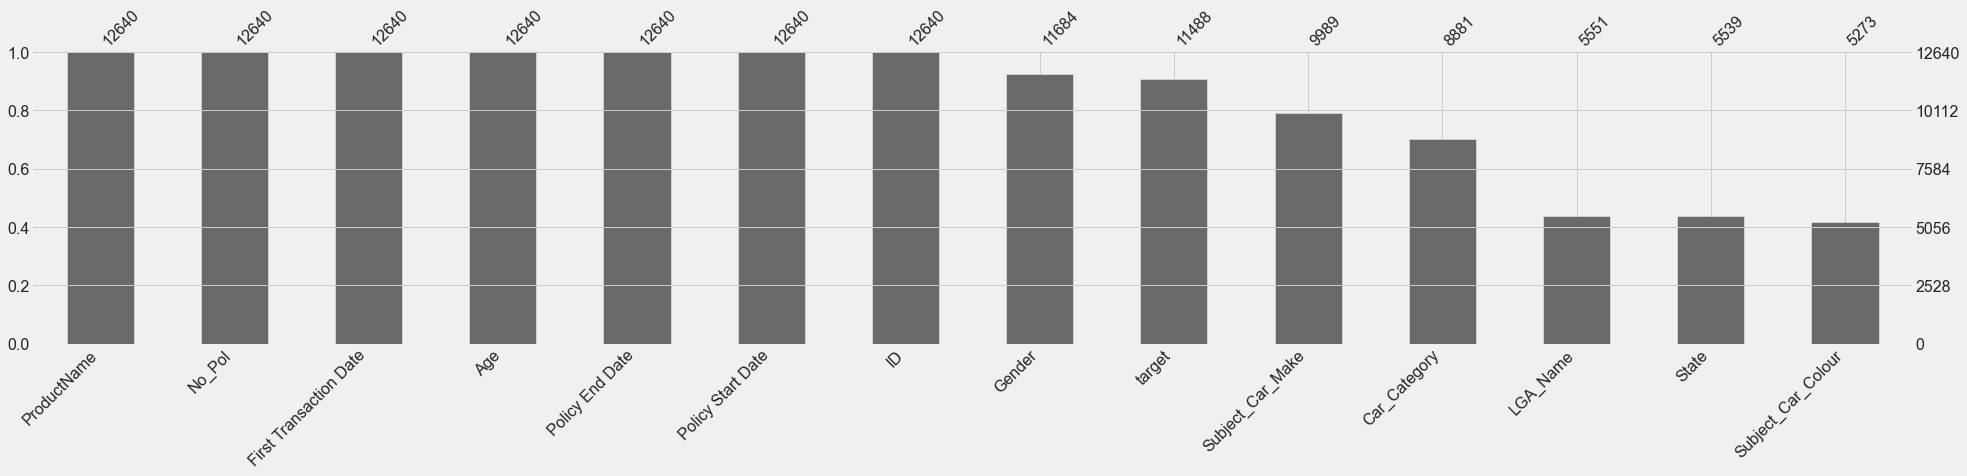

In [265]:
# Visualize the missing values in descending order
missingno.bar(alldata, sort='descending', figsize=(30, 5));

In [266]:
# No parse_dates... check dtype of "Policy_Start_Date, Policy_End_Date, First_Transaction_Date"
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12640 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      12640 non-null  object 
 1   Policy Start Date       12640 non-null  object 
 2   Policy End Date         12640 non-null  object 
 3   Gender                  11684 non-null  object 
 4   Age                     12640 non-null  int64  
 5   First Transaction Date  12640 non-null  object 
 6   No_Pol                  12640 non-null  int64  
 7   Car_Category            8881 non-null   object 
 8   Subject_Car_Colour      5273 non-null   object 
 9   Subject_Car_Make        9989 non-null   object 
 10  LGA_Name                5551 non-null   object 
 11  State                   5539 non-null   object 
 12  ProductName             12640 non-null  object 
 13  target                  11488 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

### Rename the Date Column

In [267]:
# Rename the Date columns
alldata.rename(columns = {'Policy Start Date': 'PolicyStartDate',
                          'Policy End Date': 'PolicyEndDate',
                          'First Transaction Date': 'FirstTransactionDate',
                          'ProductName': 'ProductName'},
                           inplace=True)
alldata.head()

ID PolicyStartDate PolicyEndDate  Gender  Age FirstTransactionDate  \
0  ID_0040R73      2010-05-14    2011-05-13    Male   30           2010-05-14   
1  ID_0046BNK      2010-11-29    2011-11-28  Female   79           2010-11-29   
2  ID_005QMC3      2010-03-21    2011-03-20    Male   43           2010-03-21   
3  ID_0079OHW      2010-08-21    2011-08-20    Male    2           2010-08-21   
4  ID_00BRP63      2010-08-29    2010-12-31     NaN   20           2010-08-29   

   No_Pol Car_Category Subject_Car_Colour Subject_Car_Make LGA_Name  State  \
0       1       Saloon              Black           TOYOTA      NaN    NaN   
1       1         JEEP               Grey           TOYOTA      NaN    NaN   
2       1       Saloon                Red           TOYOTA      NaN    NaN   
3       1          NaN                NaN              NaN      NaN    NaN   
4       3          NaN                NaN              NaN    Lagos  Lagos   

   ProductName  target  
0  Car Classic     0.0  
1  Car Classic     1.0  
2  Car Classic     0.0  
3      CarSafe     0.0  
4        Muuve     1.0

### Save Preprocessed data

In [268]:
# Save pre-processed data
alldata.to_csv('AutoInland-Vehicle-insurance-claim-challenge/alldata.csv', index=False)

In [269]:
# import preprocessed data with parse date
alldata = pd.read_csv('AutoInland-Vehicle-insurance-claim-challenge/alldata.csv',
                      low_memory=False,
                      parse_dates=['PolicyStartDate', 'PolicyEndDate', 'FirstTransactionDate'])
alldata.head().T

0                    1  \
ID                             ID_0040R73           ID_0046BNK   
PolicyStartDate       2010-05-14 00:00:00  2010-11-29 00:00:00   
PolicyEndDate         2011-05-13 00:00:00  2011-11-28 00:00:00   
Gender                               Male               Female   
Age                                    30                   79   
FirstTransactionDate  2010-05-14 00:00:00  2010-11-29 00:00:00   
No_Pol                                  1                    1   
Car_Category                       Saloon                 JEEP   
Subject_Car_Colour                  Black                 Grey   
Subject_Car_Make                   TOYOTA               TOYOTA   
LGA_Name                              NaN                  NaN   
State                                 NaN                  NaN   
ProductName                   Car Classic          Car Classic   
target                                0.0                  1.0   

                                        2                    3  \
ID                             ID_005QMC3           ID_0079OHW   
PolicyStartDate       2010-03-21 00:00:00  2010-08-21 00:00:00   
PolicyEndDate         2011-03-20 00:00:00  2011-08-20 00:00:00   
Gender                               Male                 Male   
Age                                    43                    2   
FirstTransactionDate  2010-03-21 00:00:00  2010-08-21 00:00:00   
No_Pol                                  1                    1   
Car_Category                       Saloon                  NaN   
Subject_Car_Colour                    Red                  NaN   
Subject_Car_Make                   TOYOTA                  NaN   
LGA_Name                              NaN                  NaN   
State                                 NaN                  NaN   
ProductName                   Car Classic              CarSafe   
target                                0.0                  0.0   

                                        4  
ID                             ID_00BRP63  
PolicyStartDate       2010-08-29 00:00:00  
PolicyEndDate         2010-12-31 00:00:00  
Gender                                NaN  
Age                                    20  
FirstTransactionDate  2010-08-29 00:00:00  
No_Pol                                  3  
Car_Category                          NaN  
Subject_Car_Colour                    NaN  
Subject_Car_Make                      NaN  
LGA_Name                            Lagos  
State                               Lagos  
ProductName                         Muuve  
target                                1.0

## **4. Feature Engineering**

<a id="features"></a>

**Engineering**: There are multiple techniques for feature engineering:

* **Decompose**: Converting 2014-09-20T20:45:40Z into categorical attributes like hour_of_the_day, part_of_day, etc.

**Imputation**: We can impute missing values in a number of different ways:

* **Hot-Deck**: The technique then finds the first missing value and uses the cell value immediately prior to the data that are missing to impute the missing value.
* **Cold-Deck**: Selects donors from another dataset to complete missing data.
* **Mean-substitution**: Another imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable.
* **Regression**: A regression model is estimated to predict observed values of a variable based on other variables, and that model is then used to impute values in cases where that variable is missing.

### Parsing dates

When working with data that has dates, it's a good idea to make sure any date data is the format of a datetime object (a Python data type which encodes specific information about dates).

In [270]:
# With parse_dates... check dtype of "Policy_Start_Date, Policy_End_Date, First_Transaction_Date"
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12640 entries, 0 to 12639
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    12640 non-null  object        
 1   PolicyStartDate       12640 non-null  datetime64[ns]
 2   PolicyEndDate         12640 non-null  datetime64[ns]
 3   Gender                11684 non-null  object        
 4   Age                   12640 non-null  int64         
 5   FirstTransactionDate  12640 non-null  datetime64[ns]
 6   No_Pol                12640 non-null  int64         
 7   Car_Category          8881 non-null   object        
 8   Subject_Car_Colour    5273 non-null   object        
 9   Subject_Car_Make      9989 non-null   object        
 10  LGA_Name              5551 non-null   object        
 11  State                 5539 non-null   object        
 12  ProductName           12640 non-null  object        
 13  target          

We've turned the `PolicyStartDate`, `PolicyEndDate`, `FirstTransactionDate` column from object datatype to datetime64 datatype.

In [271]:
alldata.PolicyStartDate.head(10)

0   2010-05-14
1   2010-11-29
2   2010-03-21
3   2010-08-21
4   2010-08-29
5   2010-10-21
6   2010-08-02
7   2010-09-12
8   2010-07-06
9   2010-12-18
Name: PolicyStartDate, dtype: datetime64[ns]

### Sort DataFrame by PolicyStartDate, PolicyEndDate, FirstTransactionDate

As we're working dates and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [272]:
# Sort Dataframe by date PolicyStartDate
alldata.sort_values(by=['PolicyStartDate'], inplace=True, ascending=True)
alldata.PolicyStartDate.head(10)

7625    2001-12-11
10013   2002-03-25
9738    2003-04-13
11476   2003-12-21
7732    2005-08-05
10187   2006-03-24
4231    2006-07-06
860     2007-03-04
1979    2009-02-26
5949    2009-08-29
Name: PolicyStartDate, dtype: datetime64[ns]

In [273]:
# Sort DataFrame by PolicyEndDate
alldata.sort_values(by=['PolicyEndDate'], inplace=True, ascending=True)
alldata.PolicyEndDate.head(10)

12194   2010-12-31
2212    2010-12-31
9884    2010-12-31
10269   2010-12-31
340     2010-12-31
11530   2010-12-31
4       2010-12-31
6728    2010-12-31
2464    2010-12-31
5556    2010-12-31
Name: PolicyEndDate, dtype: datetime64[ns]

In [274]:
# Sort DataFrame by FirstTransactionDate
alldata.sort_values(by=['FirstTransactionDate'], inplace=True, ascending=True)
alldata.FirstTransactionDate.head(10)

7625    2001-12-11
10013   2002-03-25
9738    2003-04-13
11476   2003-12-21
7732    2005-08-05
10187   2006-03-24
4231    2006-07-06
860     2007-03-04
1979    2009-02-26
5949    2009-08-29
Name: FirstTransactionDate, dtype: datetime64[ns]

### Add datetime parameters for PolicyStartDate, PolicyEndDate, FirstTransactionDate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `alldata_csv()` and we asked pandas to parse the dates using parse_dates=[`'PolicyStartDate'`, `'PolicyEndDate'`, `'FirstTransactionDate'`]), we can now access the different datetime attributes https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html of the date column.

In [275]:
# Add datetime for PolicyStartDate
alldata['PolicyStartYear'] = alldata.PolicyStartDate.dt.year
alldata['PolicyStartMonth'] = alldata.PolicyStartDate.dt.month
alldata['PolicyStartDay'] = alldata.PolicyStartDate.dt.day
alldata['PolicyStartDayofweek'] = alldata.PolicyStartDate.dt.dayofweek
alldata['PolicyStartDayofyear'] = alldata.PolicyStartDate.dt.dayofyear

# Drop original PolicyStartDate
alldata.drop("PolicyStartDate", axis=1, inplace=True)

In [276]:
# Add datetime for PolicyEndDate
alldata['PolicyEndYear'] = alldata.PolicyEndDate.dt.year
alldata['PolicyEndMonth'] = alldata.PolicyEndDate.dt.month
alldata['PolicyEndDay'] = alldata.PolicyEndDate.dt.day
alldata['PolicyEndDayofweek'] = alldata.PolicyEndDate.dt.dayofweek
alldata['PolicyEndDayofyear'] = alldata.PolicyEndDate.dt.dayofyear

# Drop original PolicyEndDate
alldata.drop("PolicyEndDate", axis=1, inplace=True)

In [277]:
# Add datetime for FirstTransactionDate
alldata['FirstTransactionYear'] = alldata.FirstTransactionDate.dt.year
alldata['FirstTransactionMonth'] = alldata.FirstTransactionDate.dt.month
alldata['FirstTransactionDay'] = alldata.FirstTransactionDate.dt.day
alldata['FirstTransactionDayofweek'] = alldata.FirstTransactionDate.dt.dayofweek
alldata['FirstTransactionDayofyear'] = alldata.FirstTransactionDate.dt.dayofyear

# Drop original FirstTransactionDate
alldata.drop("FirstTransactionDate", axis=1, inplace=True)

In [278]:
alldata.reset_index(drop=True)

ID  Gender  Age  No_Pol Car_Category Subject_Car_Colour  \
0      ID_O51ZQ1B  Female   37       1       Saloon              Black   
1      ID_VJ1FAVO    Male   37       1       Saloon              Black   
2      ID_ULWS8VL    Male   41       2       Saloon              Black   
3      ID_ZYKGSP7    Male   48       2       Saloon                NaN   
4      ID_OEWBKGF  Female   44       1          NaN                NaN   
...           ...     ...  ...     ...          ...                ...   
12635  ID_8P2UGYO    Male   20       1          NaN                NaN   
12636  ID_X7F8710    Male   38       3       Saloon             Silver   
12637  ID_ZMXI8LN    Male   36       1          NaN                NaN   
12638  ID_HNCX0NP    Male   48       1       Saloon                NaN   
12639  ID_8MNXRC6    Male   36       1       Saloon             Silver   

      Subject_Car_Make         LGA_Name   State  ProductName  ...  \
0                Honda              NaN     NaN  Car Vintage  ...   
1               TOYOTA            Ekiti   Benue  Car Classic  ...   
2               TOYOTA            Ikeja   Lagos  Car Vintage  ...   
3               Others              NaN     NaN  Car Vintage  ...   
4               Others             Ajah   Lagos         CVTP  ...   
...                ...              ...     ...          ...  ...   
12635              NaN              NaN     NaN      CarSafe  ...   
12636          Hyundai       Obia/Akpor  Rivers  Car Classic  ...   
12637              NaN              NaN     NaN      CarSafe  ...   
12638           TOYOTA              NaN     NaN      CarSafe  ...   
12639              Kia  Anthony Village   Lagos  Car Classic  ...   

       PolicyEndYear  PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  \
0               2011              12            10                   5   
1               2011               3            24                   3   
2               2011               4            12                   1   
3               2034               5            20                   5   
4               2011               9            29                   3   
...              ...             ...           ...                 ...   
12635           2011              12            30                   4   
12636           2011              12            30                   4   
12637           2011              12            29                   3   
12638           2011              12            30                   4   
12639           2011              12            16                   4   

       PolicyEndDayofyear  FirstTransactionYear  FirstTransactionMonth  \
0                     344                  2001                     12   
1                      83                  2002                      3   
2                     102                  2003                      4   
3                     140                  2003                     12   
4                     272                  2005                      8   
...                   ...                   ...                    ...   
12635                 364                  2010                     12   
12636                 364                  2010                     12   
12637                 363                  2010                     12   
12638                 364                  2010                     12   
12639                 350                  2010                     12   

       FirstTransactionDay  FirstTransactionDayofweek  \
0                       11                          1   
1                       25                          0   
2                       13                          6   
3                       21                          6   
4                        5                          4   
...                    ...                        ...   
12635                   31                          4   
12636                   31                          4   
12637 

In [279]:
alldata.head().T

7625         10013        9738         11476  \
ID                          ID_O51ZQ1B   ID_VJ1FAVO   ID_ULWS8VL   ID_ZYKGSP7   
Gender                          Female         Male         Male         Male   
Age                                 37           37           41           48   
No_Pol                               1            1            2            2   
Car_Category                    Saloon       Saloon       Saloon       Saloon   
Subject_Car_Colour               Black        Black        Black          NaN   
Subject_Car_Make                 Honda       TOYOTA       TOYOTA       Others   
LGA_Name                           NaN        Ekiti        Ikeja          NaN   
State                              NaN        Benue        Lagos          NaN   
ProductName                Car Vintage  Car Classic  Car Vintage  Car Vintage   
target                             0.0          0.0          0.0          0.0   
PolicyStartYear                   2001         2002         2003         2003   
PolicyStartMonth                    12            3            4           12   
PolicyStartDay                      11           25           13           21   
PolicyStartDayofweek                 1            0            6            6   
PolicyStartDayofyear               345           84          103          355   
PolicyEndYear                     2011         2011         2011         2034   
PolicyEndMonth                      12            3            4            5   
PolicyEndDay                        10           24           12           20   
PolicyEndDayofweek                   5            3            1            5   
PolicyEndDayofyear                 344           83          102          140   
FirstTransactionYear              2001         2002         2003         2003   
FirstTransactionMonth               12            3            4           12   
FirstTransactionDay                 11           25           13           21   
FirstTransactionDayofweek            1            0            6            6   
FirstTransactionDayofyear          345           84          103          355   

                                7732   
ID                         ID_OEWBKGF  
Gender                         Female  
Age                                44  
No_Pol                              1  
Car_Category                      NaN  
Subject_Car_Colour                NaN  
Subject_Car_Make               Others  
LGA_Name                         Ajah  
State                           Lagos  
ProductName                      CVTP  
target                            0.0  
PolicyStartYear                  2005  
PolicyStartMonth                    8  
PolicyStartDay                      5  
PolicyStartDayofweek                4  
PolicyStartDayofyear              217  
PolicyEndYear                    2011  
PolicyEndMonth                      9  
PolicyEndDay                       29  
PolicyEndDayofweek                  3  
PolicyEndDayofyear                272  
FirstTransactionYear             2005  
FirstTransactionMonth               8  
FirstTransactionDay                 5  
FirstTransactionDayofweek           4  
FirstTransactionDayofyear         217

In [280]:
# Check for missing values
alldata.isna().sum()

ID                              0
Gender                        956
Age                             0
No_Pol                          0
Car_Category                 3759
Subject_Car_Colour           7367
Subject_Car_Make             2651
LGA_Name                     7089
State                        7101
ProductName                     0
target                       1152
PolicyStartYear                 0
PolicyStartMonth                0
PolicyStartDay                  0
PolicyStartDayofweek            0
PolicyStartDayofyear            0
PolicyEndYear                   0
PolicyEndMonth                  0
PolicyEndDay                    0
PolicyEndDayofweek              0
PolicyEndDayofyear              0
FirstTransactionYear            0
FirstTransactionMonth           0
FirstTransactionDay             0
FirstTransactionDayofweek       0
FirstTransactionDayofyear       0
dtype: int64

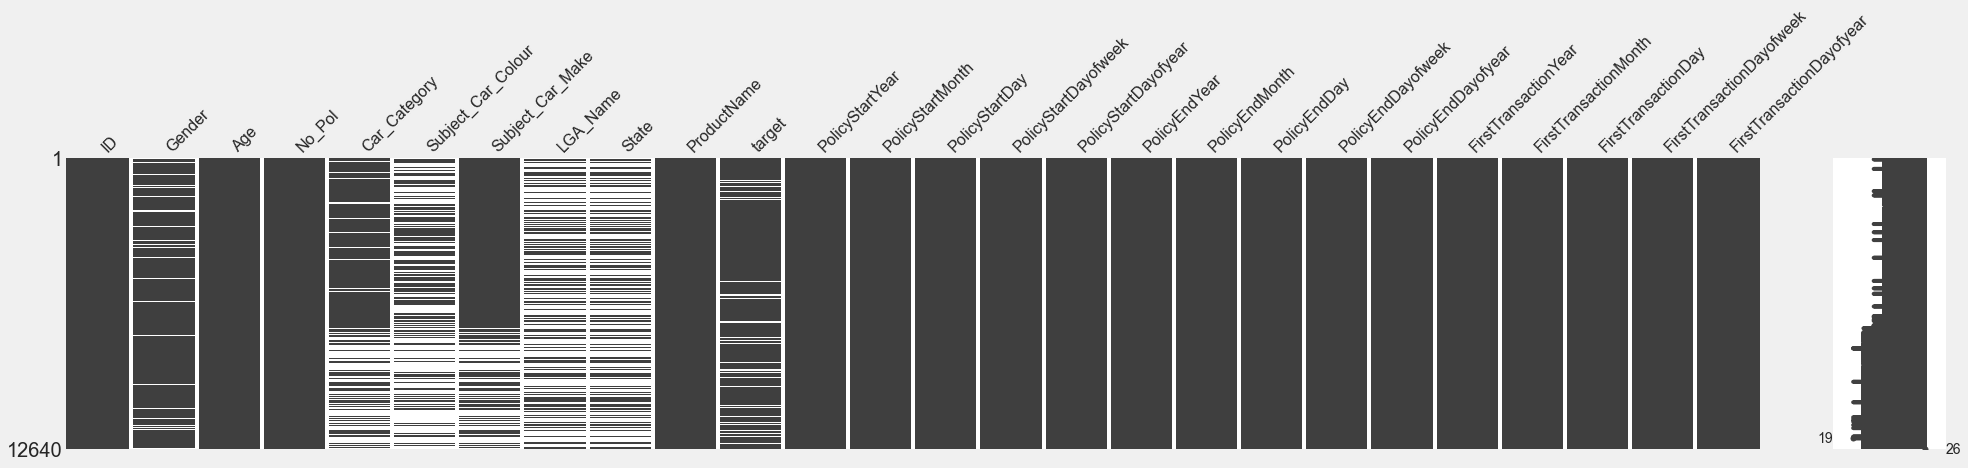

In [281]:
# Visualizing the missing values in the dataset
missingno.matrix(alldata, figsize=(30, 5));

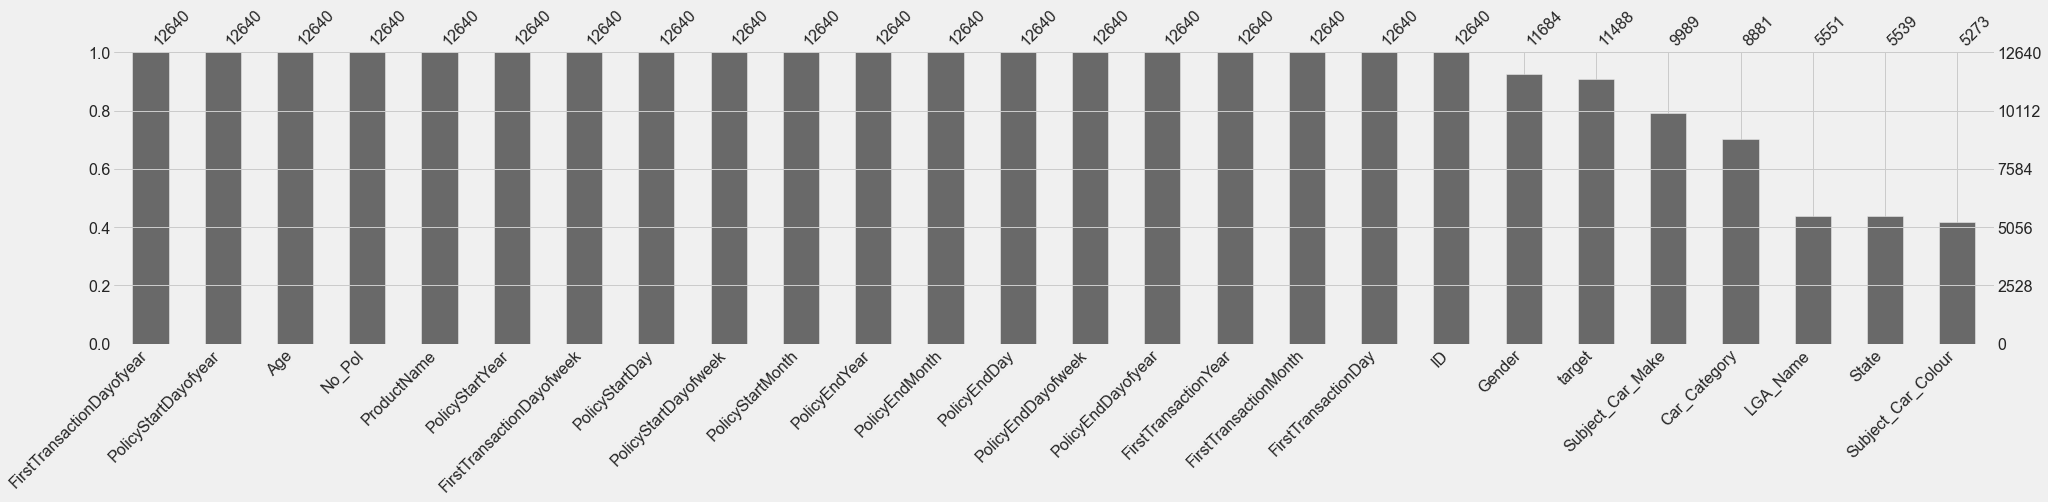

In [282]:
# Visualize the missing values in the features in descending order
missingno.bar(alldata, sort='descending', figsize=(30, 5));

In [283]:
alldata.head().T

7625         10013        9738         11476  \
ID                          ID_O51ZQ1B   ID_VJ1FAVO   ID_ULWS8VL   ID_ZYKGSP7   
Gender                          Female         Male         Male         Male   
Age                                 37           37           41           48   
No_Pol                               1            1            2            2   
Car_Category                    Saloon       Saloon       Saloon       Saloon   
Subject_Car_Colour               Black        Black        Black          NaN   
Subject_Car_Make                 Honda       TOYOTA       TOYOTA       Others   
LGA_Name                           NaN        Ekiti        Ikeja          NaN   
State                              NaN        Benue        Lagos          NaN   
ProductName                Car Vintage  Car Classic  Car Vintage  Car Vintage   
target                             0.0          0.0          0.0          0.0   
PolicyStartYear                   2001         2002         2003         2003   
PolicyStartMonth                    12            3            4           12   
PolicyStartDay                      11           25           13           21   
PolicyStartDayofweek                 1            0            6            6   
PolicyStartDayofyear               345           84          103          355   
PolicyEndYear                     2011         2011         2011         2034   
PolicyEndMonth                      12            3            4            5   
PolicyEndDay                        10           24           12           20   
PolicyEndDayofweek                   5            3            1            5   
PolicyEndDayofyear                 344           83          102          140   
FirstTransactionYear              2001         2002         2003         2003   
FirstTransactionMonth               12            3            4           12   
FirstTransactionDay                 11           25           13           21   
FirstTransactionDayofweek            1            0            6            6   
FirstTransactionDayofyear          345           84          103          355   

                                7732   
ID                         ID_OEWBKGF  
Gender                         Female  
Age                                44  
No_Pol                              1  
Car_Category                      NaN  
Subject_Car_Colour                NaN  
Subject_Car_Make               Others  
LGA_Name                         Ajah  
State                           Lagos  
ProductName                      CVTP  
target                            0.0  
PolicyStartYear                  2005  
PolicyStartMonth                    8  
PolicyStartDay                      5  
PolicyStartDayofweek                4  
PolicyStartDayofyear              217  
PolicyEndYear                    2011  
PolicyEndMonth                      9  
PolicyEndDay                       29  
PolicyEndDayofweek                  3  
PolicyEndDayofyear                272  
FirstTransactionYear             2005  
FirstTransactionMonth               8  
FirstTransactionDay                 5  
FirstTransactionDayofweek           4  
FirstTransactionDayofyear         217

In [284]:
# Check for missing categories and different datatypes
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12640 entries, 7625 to 2745
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         12640 non-null  object 
 1   Gender                     11684 non-null  object 
 2   Age                        12640 non-null  int64  
 3   No_Pol                     12640 non-null  int64  
 4   Car_Category               8881 non-null   object 
 5   Subject_Car_Colour         5273 non-null   object 
 6   Subject_Car_Make           9989 non-null   object 
 7   LGA_Name                   5551 non-null   object 
 8   State                      5539 non-null   object 
 9   ProductName                12640 non-null  object 
 10  target                     11488 non-null  float64
 11  PolicyStartYear            12640 non-null  int64  
 12  PolicyStartMonth           12640 non-null  int64  
 13  PolicyStartDay             12640 non-null  i

### Convert the strings into categories

In [285]:
# Find the columns which contains strings
for label, content in alldata.drop('ID', axis=1).items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
ProductName


In [286]:
# This will turn all strings values into categories
for label, content in alldata.items():
    if pd.api.types.is_string_dtype(content):
        alldata[label]=content.astype('category').cat.as_ordered()

In [287]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12640 entries, 7625 to 2745
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ID                         12640 non-null  category
 1   Gender                     11684 non-null  category
 2   Age                        12640 non-null  int64   
 3   No_Pol                     12640 non-null  int64   
 4   Car_Category               8881 non-null   category
 5   Subject_Car_Colour         5273 non-null   category
 6   Subject_Car_Make           9989 non-null   category
 7   LGA_Name                   5551 non-null   category
 8   State                      5539 non-null   category
 9   ProductName                12640 non-null  category
 10  target                     11488 non-null  float64 
 11  PolicyStartYear            12640 non-null  int64   
 12  PolicyStartMonth           12640 non-null  int64   
 13  PolicyStartDay             12

All of our data is categorical and thus we can now turn the categories into integers, however it's still missing values....

In [288]:
# Check the proportion of missing values
alldata.isnull().sum()/len(alldata)

ID                           0.000000
Gender                       0.075633
Age                          0.000000
No_Pol                       0.000000
Car_Category                 0.297389
Subject_Car_Colour           0.582832
Subject_Car_Make             0.209731
LGA_Name                     0.560839
State                        0.561788
ProductName                  0.000000
target                       0.091139
PolicyStartYear              0.000000
PolicyStartMonth             0.000000
PolicyStartDay               0.000000
PolicyStartDayofweek         0.000000
PolicyStartDayofyear         0.000000
PolicyEndYear                0.000000
PolicyEndMonth               0.000000
PolicyEndDay                 0.000000
PolicyEndDayofweek           0.000000
PolicyEndDayofyear           0.000000
FirstTransactionYear         0.000000
FirstTransactionMonth        0.000000
FirstTransactionDay          0.000000
FirstTransactionDayofweek    0.000000
FirstTransactionDayofyear    0.000000
dtype: float

### Filling and turning categorical variables into numbers

In [289]:
for label, content in alldata.items():
    if pd.api.types.is_categorical_dtype(content):
        print(label)

ID
Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State
ProductName


In [290]:
# Check for which categorical columns have null(missing) values
for label, content in alldata.items():
    if pd.api.types.is_categorical_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Gender
Car_Category
Subject_Car_Colour
Subject_Car_Make
LGA_Name
State


In [291]:
# Turn categorical variables into numbers
for label, content in alldata.items():
    # Check columns which are not numeric
    if not pd.api.types.is_numeric_dtype(content):
         
            # Add binary column to indicate whether sample had missing value
         alldata[label + '_is_missing'] = pd.isnull(content)
         
            # Turn categories into numbers and add +1 because pandas encodes missing categories as -1
         alldata[label] = pd.Categorical(content).codes + 1

In [292]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12640 entries, 7625 to 2745
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             12640 non-null  int16  
 1   Gender                         12640 non-null  int8   
 2   Age                            12640 non-null  int64  
 3   No_Pol                         12640 non-null  int64  
 4   Car_Category                   12640 non-null  int8   
 5   Subject_Car_Colour             12640 non-null  int8   
 6   Subject_Car_Make               12640 non-null  int8   
 7   LGA_Name                       12640 non-null  int16  
 8   State                          12640 non-null  int8   
 9   ProductName                    12640 non-null  int8   
 10  target                         11488 non-null  float64
 11  PolicyStartYear                12640 non-null  int64  
 12  PolicyStartMonth               12640 non-nul

The target column has missing values, the missing values are for the test dataset that does not have a target column, so we will leaave it.

In [293]:
alldata.target.value_counts()

0.0    10141
1.0     1347
Name: target, dtype: int64

In [294]:
alldata['target'].isnull().sum()/len(alldata)

0.09113924050632911

In [295]:
alldata.isna().sum()

ID                                  0
Gender                              0
Age                                 0
No_Pol                              0
Car_Category                        0
Subject_Car_Colour                  0
Subject_Car_Make                    0
LGA_Name                            0
State                               0
ProductName                         0
target                           1152
PolicyStartYear                     0
PolicyStartMonth                    0
PolicyStartDay                      0
PolicyStartDayofweek                0
PolicyStartDayofyear                0
PolicyEndYear                       0
PolicyEndMonth                      0
PolicyEndDay                        0
PolicyEndDayofweek                  0
PolicyEndDayofyear                  0
FirstTransactionYear                0
FirstTransactionMonth               0
FirstTransactionDay                 0
FirstTransactionDayofweek           0
FirstTransactionDayofyear           0
ID_is_missin

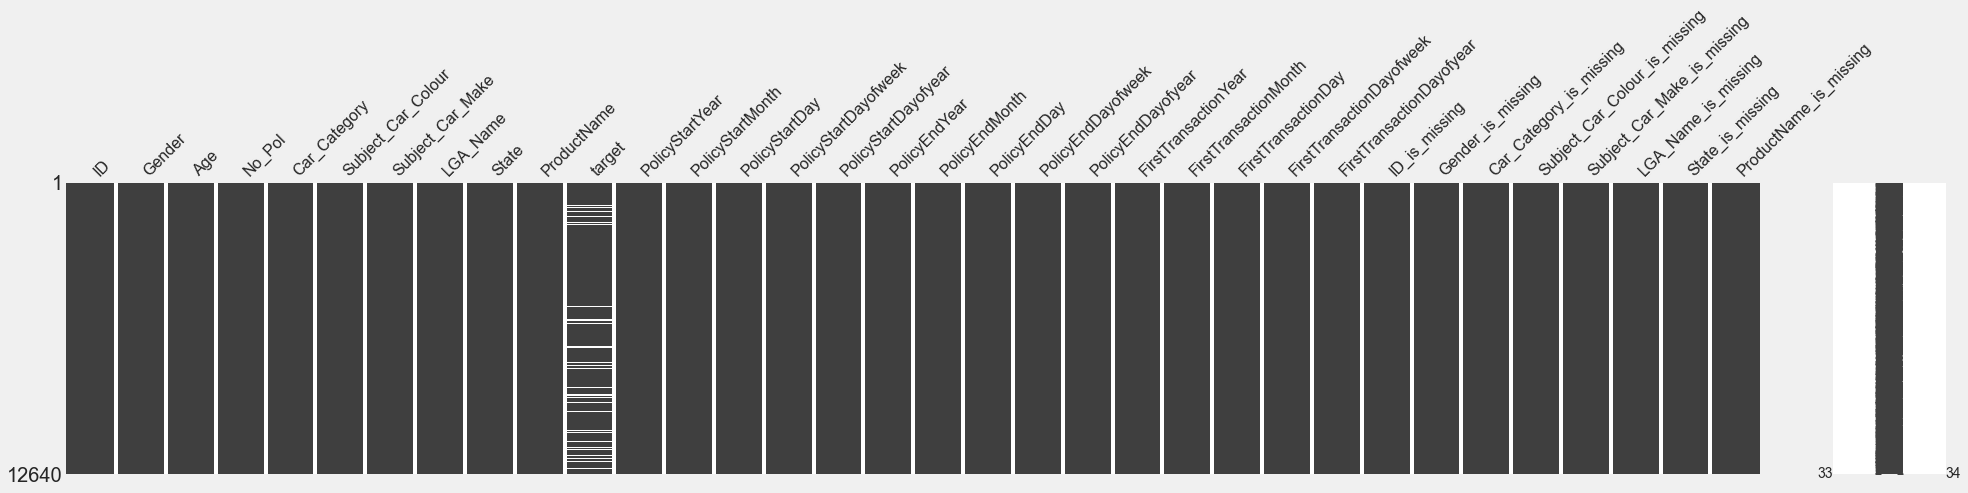

In [296]:
# Visualize if there is any missing values in the dataset after
missingno.matrix(alldata, figsize=(30, 5));

In [297]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12640 entries, 7625 to 2745
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             12640 non-null  int16  
 1   Gender                         12640 non-null  int8   
 2   Age                            12640 non-null  int64  
 3   No_Pol                         12640 non-null  int64  
 4   Car_Category                   12640 non-null  int8   
 5   Subject_Car_Colour             12640 non-null  int8   
 6   Subject_Car_Make               12640 non-null  int8   
 7   LGA_Name                       12640 non-null  int16  
 8   State                          12640 non-null  int8   
 9   ProductName                    12640 non-null  int8   
 10  target                         11488 non-null  float64
 11  PolicyStartYear                12640 non-null  int64  
 12  PolicyStartMonth               12640 non-nul

In [298]:
alldata.head().T

7625   10013  9738   11476  7732 
ID                              8409  11025  10724  12629   8524
Gender                             1      2      2      2      1
Age                               37     37     41     48     44
No_Pol                             1      1      2      2      1
Car_Category                       3      3      3      3      0
Subject_Car_Colour                 5      5      5      0      0
Subject_Car_Make                   2      9      9      8      8
LGA_Name                           0     79    124      0     25
State                              0      7     21      0     21
ProductName                        4      2      4      4      1
target                           0.0    0.0    0.0    0.0    0.0
PolicyStartYear                 2001   2002   2003   2003   2005
PolicyStartMonth                  12      3      4     12      8
PolicyStartDay                    11     25     13     21      5
PolicyStartDayofweek               1      0      6      6      4
PolicyStartDayofyear             345     84    103    355    217
PolicyEndYear                   2011   2011   2011   2034   2011
PolicyEndMonth                    12      3      4      5      9
PolicyEndDay                      10     24     12     20     29
PolicyEndDayofweek                 5      3      1      5      3
PolicyEndDayofyear               344     83    102    140    272
FirstTransactionYear            2001   2002   2003   2003   2005
FirstTransactionMonth             12      3      4     12      8
FirstTransactionDay               11     25     13     21      5
FirstTransactionDayofweek          1      0      6      6      4
FirstTransactionDayofyear        345     84    103    355    217
ID_is_missing                  False  False  False  False  False
Gender_is_missing              False  False  False  False  False
Car_Category_is_missing        False  False  False  False   True
Subject_Car_Colour_is_missing  False  False  False   True   True
Subject_Car_Make_is_missing    False  False  False  False  False
LGA_Name_is_missing             True  False  False   True  False
State_is_missing                True  False  False   True  False
ProductName_is_missing         False  False  False  False  False

### Correlation between independent variables

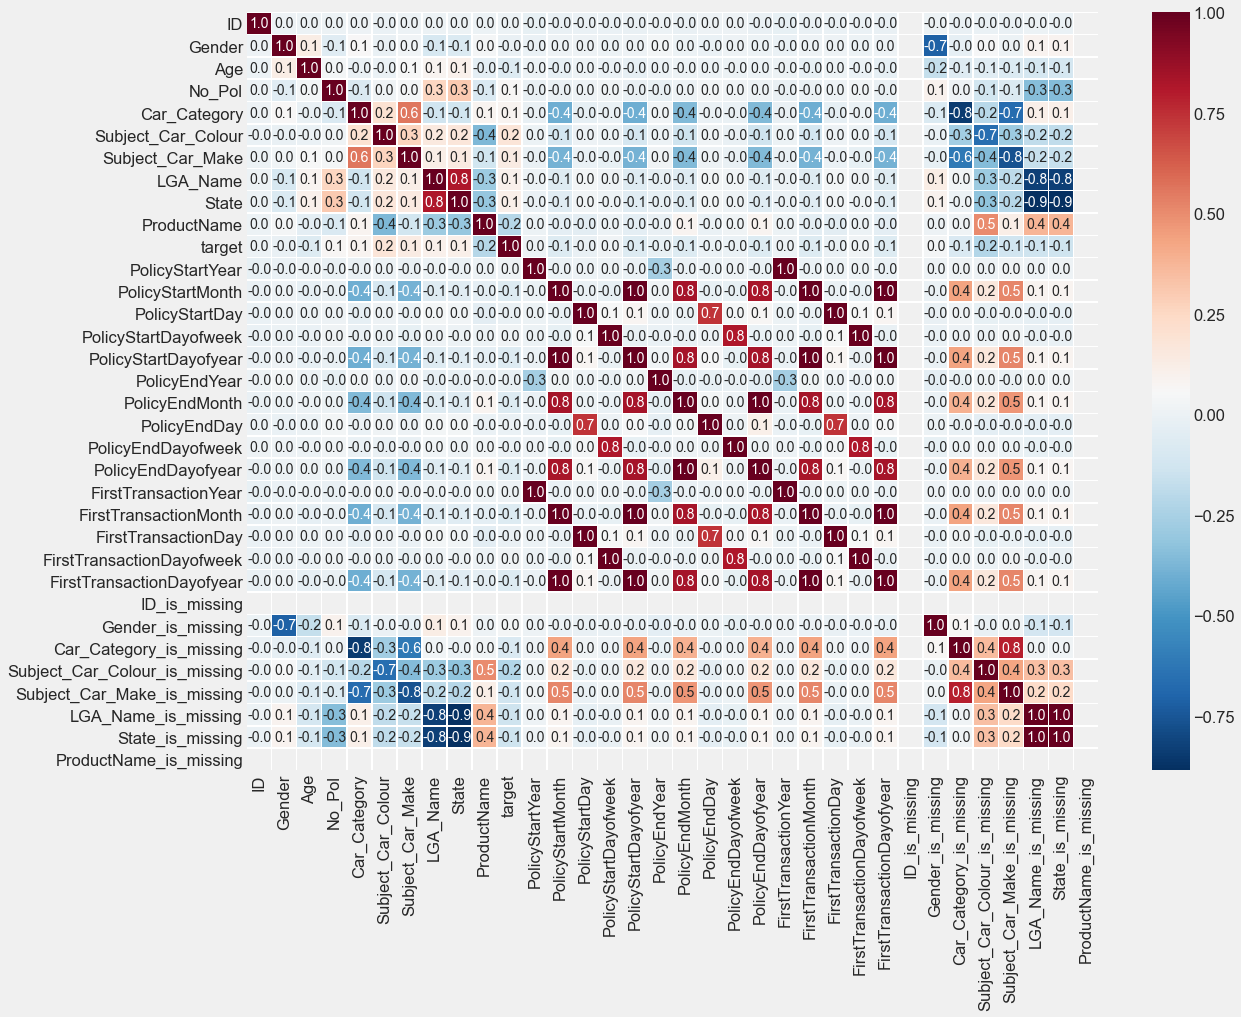

In [299]:
# Find the correlation between the independent variables
corr_matrix = alldata.corr()
plt.figure(figsize=(17, 13))
sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.5,
            fmt='.1f',
            cmap="RdBu_r");

### Splitting data into train/test sets

According to [zindi](https://zindi.africa/competitions/autoinland-vehicle-insurance-claim-challenge/data) data page, the train and test set are meant to be separate, this makes sense since we will be training the model on the train set and evaluating the model on the test set.

In [300]:
# Drop the _is_missing column
alldata.drop(['ID', 'ID_is_missing', 'Gender_is_missing', 'Car_Category_is_missing', 'Subject_Car_Colour_is_missing',
        'Subject_Car_Make_is_missing', 'LGA_Name_is_missing', 'State_is_missing', 'ProductName_is_missing'], axis=1, inplace=True)
alldata.head()

Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
7625        1   37       1             3                   5   
10013       2   37       1             3                   5   
9738        2   41       2             3                   5   
11476       2   48       2             3                   0   
7732        1   44       1             0                   0   

       Subject_Car_Make  LGA_Name  State  ProductName  target  ...  \
7625                  2         0      0            4     0.0  ...   
10013                 9        79      7            2     0.0  ...   
9738                  9       124     21            4     0.0  ...   
11476                 8         0      0            4     0.0  ...   
7732                  8        25     21            1     0.0  ...   

       PolicyEndYear  PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  \
7625            2011              12            10                   5   
10013           2011               3            24                   3   
9738            2011               4            12                   1   
11476           2034               5            20                   5   
7732            2011               9            29                   3   

       PolicyEndDayofyear  FirstTransactionYear  FirstTransactionMonth  \
7625                  344                  2001                     12   
10013                  83                  2002                      3   
9738                  102                  2003                      4   
11476                 140                  2003                     12   
7732                  272                  2005                      8   

       FirstTransactionDay  FirstTransactionDayofweek  \
7625                    11                          1   
10013                   25                          0   
9738                    13                          6   
11476                   21                          6   
7732                     5                          4   

       FirstTransactionDayofyear  
7625                         345  
10013                         84  
9738                         103  
11476                        355  
7732                         217  

[5 rows x 25 columns]

In [301]:
alldata.isna().sum()

Gender                          0
Age                             0
No_Pol                          0
Car_Category                    0
Subject_Car_Colour              0
Subject_Car_Make                0
LGA_Name                        0
State                           0
ProductName                     0
target                       1152
PolicyStartYear                 0
PolicyStartMonth                0
PolicyStartDay                  0
PolicyStartDayofweek            0
PolicyStartDayofyear            0
PolicyEndYear                   0
PolicyEndMonth                  0
PolicyEndDay                    0
PolicyEndDayofweek              0
PolicyEndDayofyear              0
FirstTransactionYear            0
FirstTransactionMonth           0
FirstTransactionDay             0
FirstTransactionDayofweek       0
FirstTransactionDayofyear       0
dtype: int64

In [302]:
# Split the concatenated data back to train and test dataset
train_n = alldata[:ntrain]
test_n = alldata[ntrain:]

In [305]:
len(train_n), len(test_n)

(12079, 561)

In [307]:
train_n.shape, test_n.shape

((12079, 25), (561, 25))

In [308]:
test_n.drop('target', axis=1, inplace=True)

In [309]:
test_n

Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
3909        0   20       2             0                   1   
8981        0   20       2             2                   1   
6309        2   40       2             0                   0   
3262        0   20       2             0                   1   
199         2   33       1             3                   0   
...       ...  ...     ...           ...                 ...   
2777        2   20       1             0                   0   
12553       2   38       3             3                  38   
11366       2   36       1             0                   0   
5611        2   48       1             3                   0   
2745        2   36       1             3                  38   

       Subject_Car_Make  LGA_Name  State  ProductName  PolicyStartYear  ...  \
3909                  8       166     21            1             2010  ...   
8981                  8       166     21            1             2010  ...   
6309                  0         0      0            2             2010  ...   
3262                  8       166     21            1             2010  ...   
199                   2         0      0            6             2010  ...   
...                 ...       ...    ...          ...              ...  ...   
2777                  0         0      0            6             2010  ...   
12553                 3       197     29            2             2010  ...   
11366                 0         0      0            6             2010  ...   
5611                  9         0      0            6             2010  ...   
2745                  4        42     21            2             2010  ...   

       PolicyEndYear  PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  \
3909            2011               6            12                   6   
8981            2011               6            12                   6   
6309            2011              12            12                   0   
3262            2011               6            12                   6   
199             2011              12            12                   0   
...              ...             ...           ...                 ...   
2777            2011              12            30                   4   
12553           2011              12            30                   4   
11366           2011              12            29                   3   
5611            2011              12            30                   4   
2745            2011              12            16                   4   

       PolicyEndDayofyear  FirstTransactionYear  FirstTransactionMonth  \
3909                  163                  2010                     12   
8981                  163                  2010                     12   
6309                  346                  2010                     12   
3262                  163                  2010                     12   
199                   346                  2010                     12   
...                   ...                   ...                    ...   
2777                  364                  2010                     12   
12553                 364                  2010                     12   
11366                 363                  2010                     12   
5611                  364                  2010                     12   
2745                  350                  2010                     12   

       FirstTransactionDay  FirstTransactionDayofweek  \
3909                    13                          0   
8981                    13                          0   
6309                    13                          0   
3262                    13                          0   
199                     13                          0   
...                    ...                        ...   
2777                    31                          4   
12553                   31                          4  

In [310]:
train_n

Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
7625        1   37       1             3                   5   
10013       2   37       1             3                   5   
9738        2   41       2             3                   5   
11476       2   48       2             3                   0   
7732        1   44       1             0                   0   
...       ...  ...     ...           ...                 ...   
9288        2   40       1             0                   0   
309         1   78       1             0                   0   
3214        1   63       1             3                  38   
1769        1   40       1             1                   0   
19          0   20       2             0                   0   

       Subject_Car_Make  LGA_Name  State  ProductName  target  ...  \
7625                  2         0      0            4     0.0  ...   
10013                 9        79      7            2     0.0  ...   
9738                  9       124     21            4     0.0  ...   
11476                 8         0      0            4     0.0  ...   
7732                  8        25     21            1     0.0  ...   
...                 ...       ...    ...          ...     ...  ...   
9288                  0         0      0            6     0.0  ...   
309                   0         0      0            2     0.0  ...   
3214                  9        10      7            2     0.0  ...   
1769                  2         0      0            6     0.0  ...   
19                    8       166     21            1     0.0  ...   

       PolicyEndYear  PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  \
7625            2011              12            10                   5   
10013           2011               3            24                   3   
9738            2011               4            12                   1   
11476           2034               5            20                   5   
7732            2011               9            29                   3   
...              ...             ...           ...                 ...   
9288            2011              12            12                   0   
309             2011              12            12                   0   
3214            2011              12            12                   0   
1769            2011              12            12                   0   
19              2011               6            12                   6   

       PolicyEndDayofyear  FirstTransactionYear  FirstTransactionMonth  \
7625                  344                  2001                     12   
10013                  83                  2002                      3   
9738                  102                  2003                      4   
11476                 140                  2003                     12   
7732                  272                  2005                      8   
...                   ...                   ...                    ...   
9288                  346                  2010                     12   
309                   346                  2010                     12   
3214                  346                  2010                     12   
1769                  346                  2010                     12   
19                    163                  2010                     12   

       FirstTransactionDay  FirstTransactionDayofweek  \
7625                    11                          1   
10013                   25                          0   
9738                    13                          6   
11476                   21                          6   
7732                     5                          4   
...                    ...                        ...   
9288                    13                          0   
309                     13                          0   
3214                    13                          0   
1769                    13                       

In [311]:
# fill the rows with nan values with the majority class
train_n = train_n.fillna({'target': 0.0})
train_n

Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
7625        1   37       1             3                   5   
10013       2   37       1             3                   5   
9738        2   41       2             3                   5   
11476       2   48       2             3                   0   
7732        1   44       1             0                   0   
...       ...  ...     ...           ...                 ...   
9288        2   40       1             0                   0   
309         1   78       1             0                   0   
3214        1   63       1             3                  38   
1769        1   40       1             1                   0   
19          0   20       2             0                   0   

       Subject_Car_Make  LGA_Name  State  ProductName  target  ...  \
7625                  2         0      0            4     0.0  ...   
10013                 9        79      7            2     0.0  ...   
9738                  9       124     21            4     0.0  ...   
11476                 8         0      0            4     0.0  ...   
7732                  8        25     21            1     0.0  ...   
...                 ...       ...    ...          ...     ...  ...   
9288                  0         0      0            6     0.0  ...   
309                   0         0      0            2     0.0  ...   
3214                  9        10      7            2     0.0  ...   
1769                  2         0      0            6     0.0  ...   
19                    8       166     21            1     0.0  ...   

       PolicyEndYear  PolicyEndMonth  PolicyEndDay  PolicyEndDayofweek  \
7625            2011              12            10                   5   
10013           2011               3            24                   3   
9738            2011               4            12                   1   
11476           2034               5            20                   5   
7732            2011               9            29                   3   
...              ...             ...           ...                 ...   
9288            2011              12            12                   0   
309             2011              12            12                   0   
3214            2011              12            12                   0   
1769            2011              12            12                   0   
19              2011               6            12                   6   

       PolicyEndDayofyear  FirstTransactionYear  FirstTransactionMonth  \
7625                  344                  2001                     12   
10013                  83                  2002                      3   
9738                  102                  2003                      4   
11476                 140                  2003                     12   
7732                  272                  2005                      8   
...                   ...                   ...                    ...   
9288                  346                  2010                     12   
309                   346                  2010                     12   
3214                  346                  2010                     12   
1769                  346                  2010                     12   
19                    163                  2010                     12   

       FirstTransactionDay  FirstTransactionDayofweek  \
7625                    11                          1   
10013                   25                          0   
9738                    13                          6   
11476                   21                          6   
7732                     5                          4   
...                    ...                        ...   
9288                    13                          0   
309                     13                          0   
3214                    13                          0   
1769                    13                       

In [312]:
train_n['target'].value_counts()

0.0    10765
1.0     1314
Name: target, dtype: int64

In [313]:
# Change the target column from float to int
train_n.target = train_n.target.astype(int)

### Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

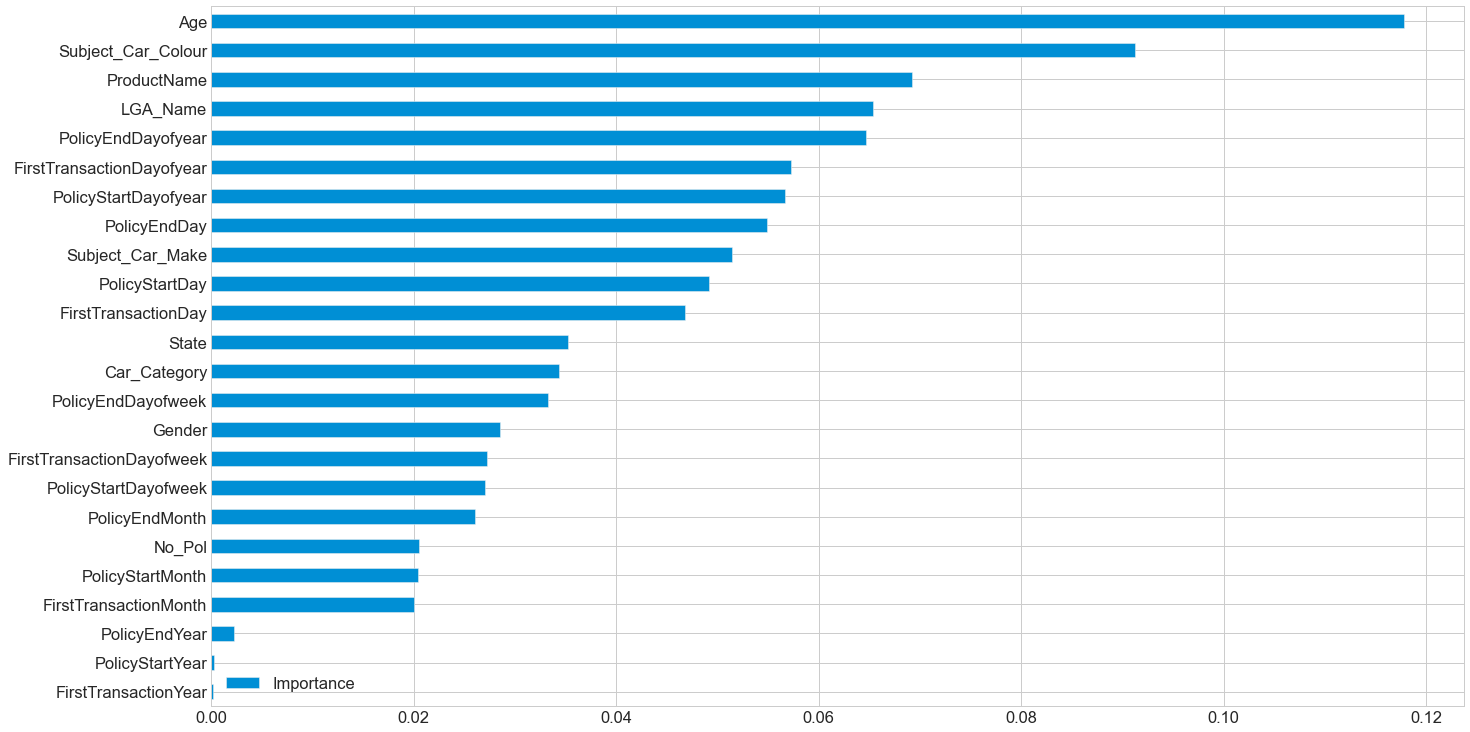

In [316]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(train_n.drop('target', axis=1), train_n['target'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=train_n.drop('target', axis=1).columns, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20, len(importance)/2));

In [317]:
print('Rows containing 0 =', len(train_n[train_n['target']==0]))
print('Rows containing 1 =', len(train_n[train_n['target']==1]))

Rows containing 0 = 10765
Rows containing 1 = 1314


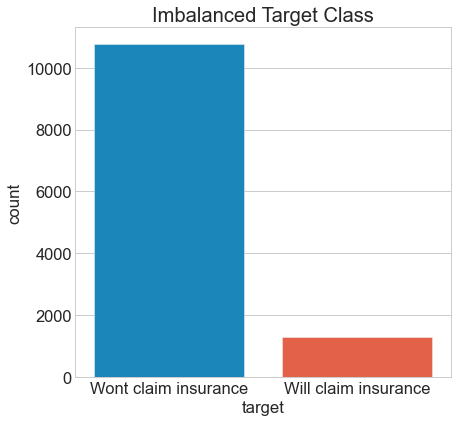

In [318]:
# Visualize the target variable with a bar graph
plt.figure(figsize=(6, 6))
g = sns.countplot('target', data=train_n)
plt.title('Imbalanced Target Class')
g.set_xticklabels(['Wont claim insurance', 'Will claim insurance'])
plt.show();

In [319]:
len(train_n)

12079

### Split the Training Dataset

In [320]:
# Split the training dataset into X and y
X = train_n.drop('target', axis = 1)
y = train_n['target']

In [321]:
X.shape, y.shape

((12079, 24), (12079,))

### Checking for Imbalanced Classification:

In [322]:
y.value_counts()

0    10765
1     1314
Name: target, dtype: int64

<AxesSubplot:>

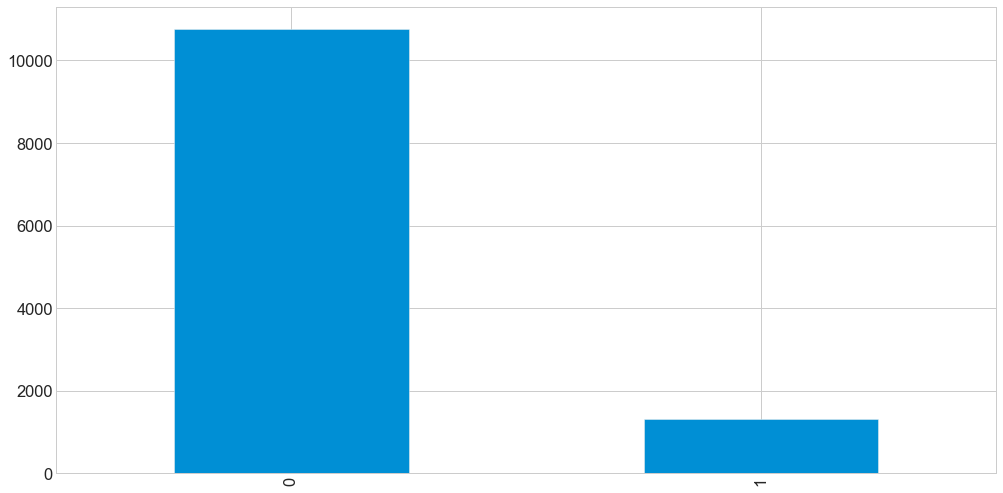

In [323]:
y.value_counts().plot(kind='bar')

## **5. Modelling**

<a id="models"></a>

### **What is Data Imbalance?**

Data imbalance usually reflects an unequal distribution of classes within a dataset. As with the data set we're working with, The proportion of customers who will claim a car insurance in the first 3 months and customers who will not claim a car insurance in the first 3 months is about 8.13 : 1. If we train our binary classification model without fixing this problem, the model will be completely biased towards the customers who will not claim a car insurance in the first 3 months. Since all of our data is numeric and there are no missing values and we have a highly imbalanced class, we'll attempt to balance the dataset by OverSampling and Undersampling the majority and minority class.

### Applying Oversampling technique for the training dataset(Random Oversampling Minority class)

With my training data created, I’ll upsample the minority class using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE creates synthetic observations of the minority class by:

* Finding the k-nearest-neighbors for minority class observations (finding similar observations)
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

After upsampling to a class ratio of 1.0, I should have a balanced dataset. There’s no need (and often it’s not smart) to balance the classes, but it magnifies the issue caused by incorrectly timed oversampling.

In [324]:
# summarize class distribution
print("Before Oversampling: ", Counter(y))

# over = RandomOverSampler(sampling_strategy='minority')
sm = SMOTE(sampling_strategy='minority', random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

Counter(y_sm)
print(f"After Oversampling: {Counter(y_sm)}")

Before Oversampling:  Counter({0: 10765, 1: 1314})
After Oversampling: Counter({0: 10765, 1: 10765})


<AxesSubplot:>

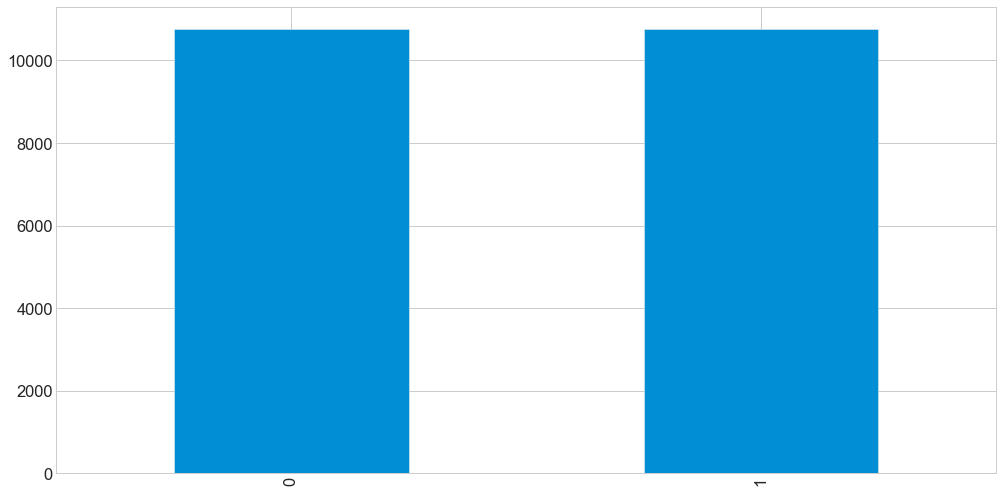

In [325]:
y_sm.value_counts().plot(kind='bar')

In [326]:
X_sm.shape, y_sm.shape

((21530, 24), (21530,))

In [327]:
# Train with the new data
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2, random_state = 42)

In [328]:
len(X_train), len(y_test)

(17224, 4306)

We're going to be using 6 models to evaluate the sampled dataset:

* Logistic Regression
* RandomForestClassifier
* KNeighborClassifier
* LGBMClassifier
* CatBoostClassifier
* XGBClassifier

All of the algorithms in the Scikit-Learn library use the same functions, for training a model, model.fit(X_train, y_train) and for scoring a model model.score(X_test, y_test). score() returns the ratio of correct predictions (1.0 = 100% correct).

Metrics:

* Precision is the total number of customers the model correctly identified as customers that will claim insurance out of all the people PREDICTED to claim insurance

* Recall is the total number of people the model correctly identified as customers that will claim insurance out of all the people who ACTUALLY claimed insurance.

* Accuracy is the total number of correct predictions divided by the total number of predictions.

* It is not possible to achieve both a high precision and a high recall value- we must determine which is more important for us in our model.

* F1 gives us the harmonic mean of precision and recall (Aim for a high F1 value to indicate a good precision and a good recall value).

* ROC (Receiver Operating Characteristic) Curve is a plot betwen the True Positive Rate on the y-axis and the False Positive Rate on the x-axis. A plot with the graph closer to the left and top axes is indicative of a better model.

* AUC (Area Under Curve) values range from 0 to 1 with higher scores indicating a better model. The diagonal line on ROC curves usually represents a random model with an AUC of 0.5. (Would definitely want our model's AUC to be higher than 0.5, since that would signify it is better than random chance.

* PRC (Precision-Recall Curves) plot values of precision scores on the y-axis and recall on the x-axis. A plot with the graph closer to the top and right axes is indicative of a better model. As with ROC curves, we should aim for a high AUC.

### 5.1 Logistic Regression

<a id="logreg"></a>

In [329]:
# Logistic Regression
np.random.seed(42)

# Instantiate the model
log = LogisticRegression()

# Fit the model on the train data
log.fit(X_train, y_train)

# Score the model on the test data
log.score(X_test, y_test)

0.706223873664654

In [330]:
# Make predictions on the model
log_pred = log.predict(X_test)
log_pred[:10]

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1])

In [331]:
y_test[:10]

423      0
3522     0
15068    1
20594    1
4351     0
3002     0
9841     0
2830     0
14825    1
16762    1
Name: target, dtype: int32

In [332]:
print(classification_report(y_test, log_pred));

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      2188
           1       0.68      0.76      0.72      2118

    accuracy                           0.71      4306
   macro avg       0.71      0.71      0.71      4306
weighted avg       0.71      0.71      0.71      4306



In [333]:
print('Precision Score: ', round(precision_score(y_test, log_pred), 2))
print('Recall Score: ', round(recall_score(y_test, log_pred), 2))
print('F1 Score: ', round(f1_score(y_test, log_pred), 2))
print('Accuracy Score: ', round(accuracy_score(y_test, log_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, log_pred), 2))

Precision Score:  0.68
Recall Score:  0.76
F1 Score:  0.72
Accuracy Score:  0.71
ROC AUC:  0.71


### 5.1.1 Confusion Matrix of LogisticRegression Model

<a id="logreg"></a>

[[1424  764]
 [ 501 1617]]


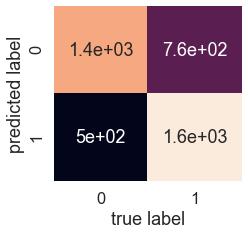

In [334]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, log_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, log_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, log_pred)
print(confusion_matrix(y_test, log_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 764 occasaions where the model predicted 0 when it should've been 1 (false negative) and 501 occasions where the model predicted 1 instead of 0 (false positive).

### 5.1.2 ROC Curve and AUC Scores for the Logistic Regression model

<a id="logreg"></a>

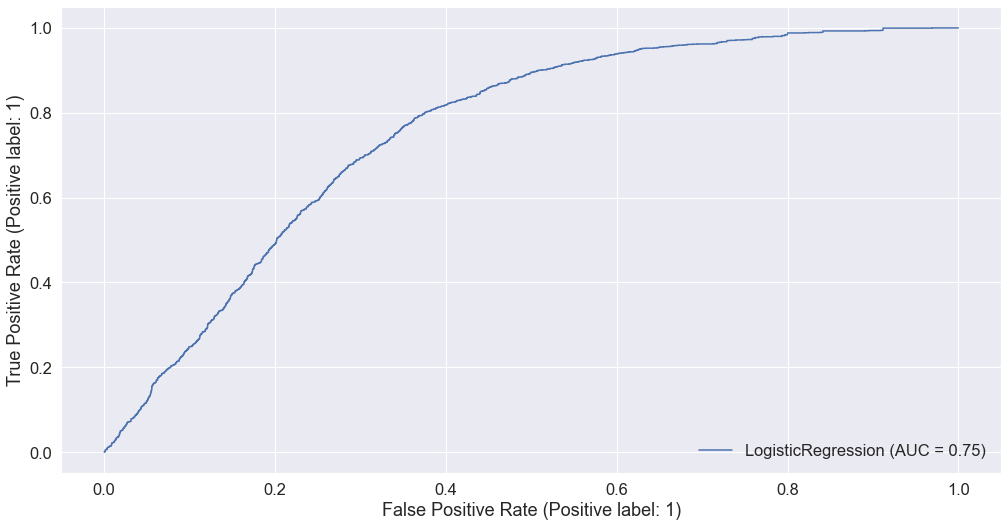

In [335]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(log, X_test, y_test);

### 5.2 Random Forest

<a id="forest"></a>

In [336]:
# Random Forest
np.random.seed(42)

# Instantiate the model
rf = RandomForestClassifier()

# # Fit the model on the training data
rf.fit(X_train, y_train)

# Score the model on the test data
rf.score(X_test, y_test)

0.8994426381792847

In [337]:
# Make predictions on the model
rf_pred = rf.predict(X_test)
rf_pred[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1])

In [338]:
y_test[:10]

423      0
3522     0
15068    1
20594    1
4351     0
3002     0
9841     0
2830     0
14825    1
16762    1
Name: target, dtype: int32

In [339]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      2188
           1       0.87      0.94      0.90      2118

    accuracy                           0.90      4306
   macro avg       0.90      0.90      0.90      4306
weighted avg       0.90      0.90      0.90      4306



In [340]:
print('Precision Score:', round(precision_score(y_test, rf_pred), 2))
print('Recall Score:', round(recall_score(y_test, rf_pred), 2))
print('F1 Score:', round(f1_score(y_test, rf_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, rf_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, rf_pred), 2))

Precision Score: 0.87
Recall Score: 0.94
F1 Score: 0.9
Accuracy Score: 0.9
ROC AUC:  0.9


### 5.2.1 Confusion Matrix of RandomForest Model

<a id="forest"></a>

[[1887  301]
 [ 132 1986]]


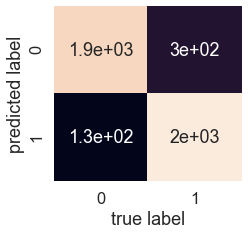

In [341]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, rf_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, rf_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, rf_pred)
print(confusion_matrix(y_test, rf_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 301 occasaions where the model predicted 0 when it should've been 1 (false negative) and 132 occasions where the model predicted 1 instead of 0 (false positive).

### 5.2.2 ROC Curve and AUC Scores for the RandomForestClassifier Model

<a id="forest"></a>

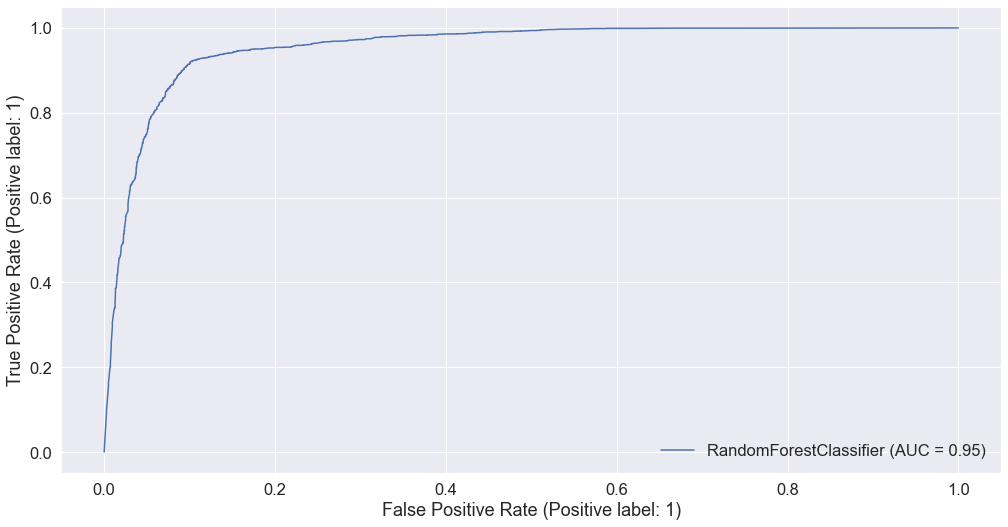

In [342]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rf, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.95. But a perfect model would achieve an AUC score of 1.0.

### 5.3 KNeighborsClassifier

<a id="neighbors"></a>

In [343]:
np.random.seed(42)

# Instantiate the model
knn = KNeighborsClassifier()

# Fit the model to the training data
knn.fit(X_train, y_train)

# Score the model on the test data
knn.score(X_test, y_test)

0.8506734788666976

In [344]:
# Make predictions on the model
knn_pred = knn.predict(X_test)
knn_pred[:10]

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1])

In [345]:
y_test[:10]

423      0
3522     0
15068    1
20594    1
4351     0
3002     0
9841     0
2830     0
14825    1
16762    1
Name: target, dtype: int32

In [346]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      2188
           1       0.78      0.97      0.86      2118

    accuracy                           0.85      4306
   macro avg       0.87      0.85      0.85      4306
weighted avg       0.87      0.85      0.85      4306



In [347]:
print('Precision Score:', round(precision_score(y_test, knn_pred), 2))
print('Recall Score:', round(recall_score(y_test, knn_pred), 2))
print('F1 Score:', round(f1_score(y_test, knn_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, knn_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, knn_pred), 2))

Precision Score: 0.78
Recall Score: 0.97
F1 Score: 0.86
Accuracy Score: 0.85
ROC AUC:  0.85


### 5.3.1 Confusion Matrix of KNeighborsClassifier Model

<a id="neighbors"></a>

[[1613  575]
 [  68 2050]]


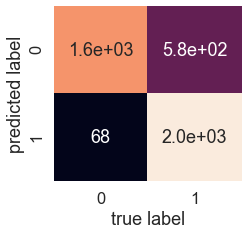

In [348]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, knn_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, knn_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, knn_pred)
print(confusion_matrix(y_test, knn_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 575 occasaions where the model predicted 0 when it should've been 1 (false negative) and 68 occasions where the model predicted 1 instead of 0 (false positive).

### 5.3.2 ROC Curve and AUC Scores for the KNeighborsClassifier Model

<a id="neighbors"></a>

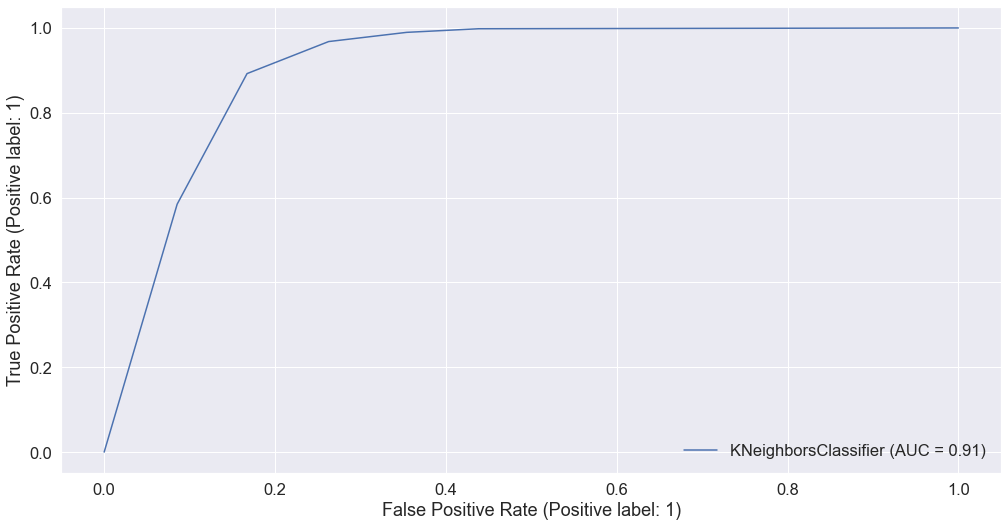

In [349]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(knn, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.91. But a perfect model would achieve an AUC score of 1.0.

### 5.4 LightGBM Model

<a id="lgbm"></a>

In [350]:
np.random.seed(42)

# Instantiate the model
lgbm = LGBMClassifier()

# Fit the model
lgbm.fit(X_train, y_train)

# Score the model on the test data
lgbm.score(X_test, y_test)

0.882954017649791

In [351]:
# Make predictions on the model
lgbm_pred = lgbm.predict(X_test)
lgbm_pred[:10]

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [352]:
y_test[:10]

423      0
3522     0
15068    1
20594    1
4351     0
3002     0
9841     0
2830     0
14825    1
16762    1
Name: target, dtype: int32

In [353]:
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2188
           1       0.85      0.92      0.89      2118

    accuracy                           0.88      4306
   macro avg       0.88      0.88      0.88      4306
weighted avg       0.89      0.88      0.88      4306



In [354]:
print('Precision Score:', round(precision_score(y_test, lgbm_pred), 2))
print('Recall Score:', round(recall_score(y_test, lgbm_pred), 2))
print('F1 Score:', round(f1_score(y_test, lgbm_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, lgbm_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, lgbm_pred), 2))

Precision Score: 0.85
Recall Score: 0.92
F1 Score: 0.89
Accuracy Score: 0.88
ROC AUC:  0.88


### 5.4.1 Confusion Matrix of LightGBMClassifier Model

<a id="neighbors"></a>

[[1857  331]
 [ 173 1945]]


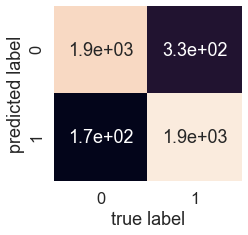

In [355]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, lgbm_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, lgbm_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, lgbm_pred)
print(confusion_matrix(y_test, lgbm_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 331 occasaions where the model predicted 0 when it should've been 1 (false negative) and 173 occasions where the model predicted 1 instead of 0 (false positive).

### 5.4.2 ROC Curve and AUC Scores for the LightGBMClassifier Model

<a id="neighbors"></a>

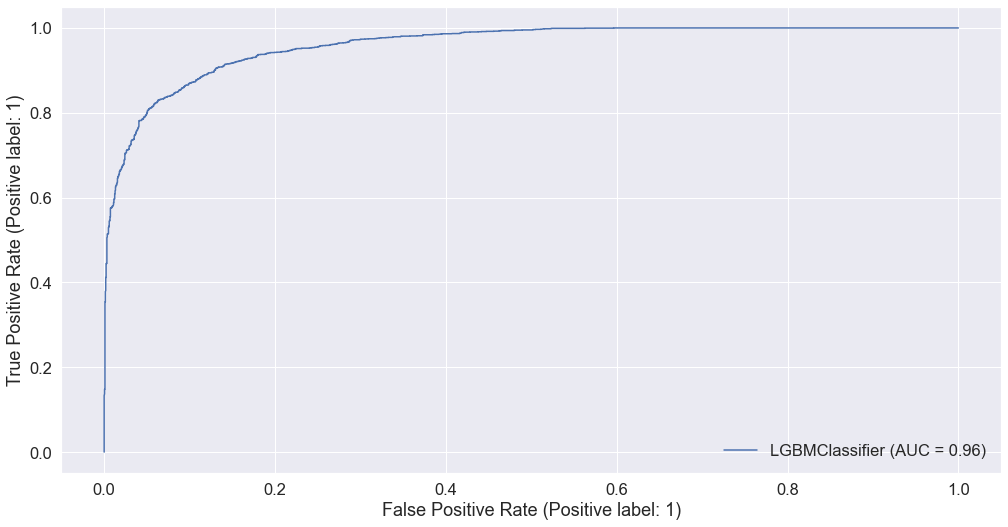

In [356]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(lgbm, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.96. But a perfect model would achieve an AUC score of 1.0.

### 5.5 CatBoost Model

<a id="catboost"></a>

In [357]:
np. random.seed(42)

# Instantiate the model
cat = CatBoostClassifier()

# Fit the model to the training data
cat.fit(X_train, y_train)

# Score the model on the test data
cat.score(X_test, y_test)

Learning rate set to 0.034735
0:	learn: 0.6722268	total: 24.1ms	remaining: 24.1s
1:	learn: 0.6566857	total: 43.5ms	remaining: 21.7s
2:	learn: 0.6392283	total: 64.6ms	remaining: 21.5s
3:	learn: 0.6232343	total: 85.5ms	remaining: 21.3s
4:	learn: 0.6098614	total: 108ms	remaining: 21.5s
5:	learn: 0.5994092	total: 129ms	remaining: 21.4s
6:	learn: 0.5868259	total: 148ms	remaining: 21.1s
7:	learn: 0.5763013	total: 168ms	remaining: 20.8s
8:	learn: 0.5678086	total: 186ms	remaining: 20.5s
9:	learn: 0.5584945	total: 210ms	remaining: 20.8s
10:	learn: 0.5499398	total: 228ms	remaining: 20.5s
11:	learn: 0.5455075	total: 248ms	remaining: 20.5s
12:	learn: 0.5391939	total: 268ms	remaining: 20.4s
13:	learn: 0.5326111	total: 287ms	remaining: 20.2s
14:	learn: 0.5288365	total: 306ms	remaining: 20.1s
15:	learn: 0.5254097	total: 329ms	remaining: 20.2s
16:	learn: 0.5216363	total: 348ms	remaining: 20.1s
17:	learn: 0.5166058	total: 367ms	remaining: 20s
18:	learn: 0.5120353	total: 387ms	remaining: 20s
19:	learn: 

170:	learn: 0.3585420	total: 3.32s	remaining: 16.1s
171:	learn: 0.3583361	total: 3.34s	remaining: 16.1s
172:	learn: 0.3577983	total: 3.36s	remaining: 16.1s
173:	learn: 0.3573807	total: 3.38s	remaining: 16s
174:	learn: 0.3571251	total: 3.39s	remaining: 16s
175:	learn: 0.3566536	total: 3.41s	remaining: 16s
176:	learn: 0.3563102	total: 3.43s	remaining: 15.9s
177:	learn: 0.3560901	total: 3.44s	remaining: 15.9s
178:	learn: 0.3555400	total: 3.46s	remaining: 15.9s
179:	learn: 0.3551383	total: 3.47s	remaining: 15.8s
180:	learn: 0.3548096	total: 3.49s	remaining: 15.8s
181:	learn: 0.3545833	total: 3.5s	remaining: 15.8s
182:	learn: 0.3543527	total: 3.52s	remaining: 15.7s
183:	learn: 0.3540848	total: 3.54s	remaining: 15.7s
184:	learn: 0.3536842	total: 3.56s	remaining: 15.7s
185:	learn: 0.3533598	total: 3.57s	remaining: 15.6s
186:	learn: 0.3529696	total: 3.59s	remaining: 15.6s
187:	learn: 0.3524497	total: 3.61s	remaining: 15.6s
188:	learn: 0.3521108	total: 3.63s	remaining: 15.6s
189:	learn: 0.35179

330:	learn: 0.3072573	total: 6.21s	remaining: 12.6s
331:	learn: 0.3070410	total: 6.23s	remaining: 12.5s
332:	learn: 0.3067523	total: 6.25s	remaining: 12.5s
333:	learn: 0.3064192	total: 6.28s	remaining: 12.5s
334:	learn: 0.3063256	total: 6.29s	remaining: 12.5s
335:	learn: 0.3061068	total: 6.31s	remaining: 12.5s
336:	learn: 0.3057100	total: 6.33s	remaining: 12.5s
337:	learn: 0.3054384	total: 6.35s	remaining: 12.4s
338:	learn: 0.3050641	total: 6.37s	remaining: 12.4s
339:	learn: 0.3048214	total: 6.39s	remaining: 12.4s
340:	learn: 0.3047338	total: 6.41s	remaining: 12.4s
341:	learn: 0.3044541	total: 6.43s	remaining: 12.4s
342:	learn: 0.3042701	total: 6.45s	remaining: 12.4s
343:	learn: 0.3040502	total: 6.47s	remaining: 12.3s
344:	learn: 0.3038921	total: 6.49s	remaining: 12.3s
345:	learn: 0.3036291	total: 6.5s	remaining: 12.3s
346:	learn: 0.3033720	total: 6.52s	remaining: 12.3s
347:	learn: 0.3030758	total: 6.54s	remaining: 12.3s
348:	learn: 0.3029299	total: 6.56s	remaining: 12.2s
349:	learn: 0

489:	learn: 0.2732775	total: 9.04s	remaining: 9.41s
490:	learn: 0.2730859	total: 9.06s	remaining: 9.4s
491:	learn: 0.2728957	total: 9.08s	remaining: 9.38s
492:	learn: 0.2726734	total: 9.1s	remaining: 9.36s
493:	learn: 0.2724162	total: 9.12s	remaining: 9.34s
494:	learn: 0.2723349	total: 9.13s	remaining: 9.31s
495:	learn: 0.2720904	total: 9.15s	remaining: 9.29s
496:	learn: 0.2718198	total: 9.16s	remaining: 9.27s
497:	learn: 0.2716677	total: 9.18s	remaining: 9.25s
498:	learn: 0.2714300	total: 9.19s	remaining: 9.23s
499:	learn: 0.2712852	total: 9.21s	remaining: 9.21s
500:	learn: 0.2710429	total: 9.22s	remaining: 9.19s
501:	learn: 0.2708644	total: 9.24s	remaining: 9.17s
502:	learn: 0.2706643	total: 9.26s	remaining: 9.15s
503:	learn: 0.2705022	total: 9.28s	remaining: 9.13s
504:	learn: 0.2704769	total: 9.29s	remaining: 9.11s
505:	learn: 0.2704482	total: 9.31s	remaining: 9.09s
506:	learn: 0.2704246	total: 9.32s	remaining: 9.06s
507:	learn: 0.2702402	total: 9.34s	remaining: 9.04s
508:	learn: 0.

655:	learn: 0.2464177	total: 12s	remaining: 6.27s
656:	learn: 0.2462977	total: 12s	remaining: 6.25s
657:	learn: 0.2462772	total: 12s	remaining: 6.23s
658:	learn: 0.2461144	total: 12s	remaining: 6.21s
659:	learn: 0.2459779	total: 12s	remaining: 6.2s
660:	learn: 0.2458546	total: 12s	remaining: 6.18s
661:	learn: 0.2457630	total: 12.1s	remaining: 6.16s
662:	learn: 0.2456423	total: 12.1s	remaining: 6.14s
663:	learn: 0.2456244	total: 12.1s	remaining: 6.12s
664:	learn: 0.2455197	total: 12.1s	remaining: 6.1s
665:	learn: 0.2453927	total: 12.1s	remaining: 6.08s
666:	learn: 0.2451833	total: 12.2s	remaining: 6.07s
667:	learn: 0.2450215	total: 12.2s	remaining: 6.05s
668:	learn: 0.2448770	total: 12.2s	remaining: 6.04s
669:	learn: 0.2447603	total: 12.2s	remaining: 6.02s
670:	learn: 0.2446097	total: 12.2s	remaining: 6s
671:	learn: 0.2444696	total: 12.3s	remaining: 5.98s
672:	learn: 0.2443557	total: 12.3s	remaining: 5.97s
673:	learn: 0.2442517	total: 12.3s	remaining: 5.95s
674:	learn: 0.2442127	total: 

816:	learn: 0.2263626	total: 14.9s	remaining: 3.33s
817:	learn: 0.2262582	total: 14.9s	remaining: 3.31s
818:	learn: 0.2261343	total: 14.9s	remaining: 3.29s
819:	learn: 0.2259827	total: 14.9s	remaining: 3.27s
820:	learn: 0.2258583	total: 14.9s	remaining: 3.25s
821:	learn: 0.2257393	total: 14.9s	remaining: 3.23s
822:	learn: 0.2256165	total: 15s	remaining: 3.22s
823:	learn: 0.2254920	total: 15s	remaining: 3.2s
824:	learn: 0.2254075	total: 15s	remaining: 3.18s
825:	learn: 0.2252945	total: 15s	remaining: 3.16s
826:	learn: 0.2251447	total: 15s	remaining: 3.14s
827:	learn: 0.2250356	total: 15s	remaining: 3.12s
828:	learn: 0.2249429	total: 15s	remaining: 3.1s
829:	learn: 0.2247978	total: 15.1s	remaining: 3.08s
830:	learn: 0.2247043	total: 15.1s	remaining: 3.07s
831:	learn: 0.2246046	total: 15.1s	remaining: 3.05s
832:	learn: 0.2245381	total: 15.1s	remaining: 3.03s
833:	learn: 0.2244287	total: 15.1s	remaining: 3.01s
834:	learn: 0.2242945	total: 15.2s	remaining: 2.99s
835:	learn: 0.2241878	total:

975:	learn: 0.2110971	total: 17.5s	remaining: 430ms
976:	learn: 0.2109991	total: 17.5s	remaining: 413ms
977:	learn: 0.2109317	total: 17.5s	remaining: 395ms
978:	learn: 0.2108054	total: 17.6s	remaining: 377ms
979:	learn: 0.2106841	total: 17.6s	remaining: 359ms
980:	learn: 0.2106031	total: 17.6s	remaining: 341ms
981:	learn: 0.2104794	total: 17.6s	remaining: 323ms
982:	learn: 0.2104155	total: 17.6s	remaining: 305ms
983:	learn: 0.2102874	total: 17.6s	remaining: 287ms
984:	learn: 0.2101888	total: 17.7s	remaining: 269ms
985:	learn: 0.2101002	total: 17.7s	remaining: 251ms
986:	learn: 0.2099959	total: 17.7s	remaining: 233ms
987:	learn: 0.2098870	total: 17.7s	remaining: 215ms
988:	learn: 0.2097638	total: 17.7s	remaining: 197ms
989:	learn: 0.2096764	total: 17.7s	remaining: 179ms
990:	learn: 0.2095848	total: 17.8s	remaining: 161ms
991:	learn: 0.2095162	total: 17.8s	remaining: 143ms
992:	learn: 0.2094570	total: 17.8s	remaining: 126ms
993:	learn: 0.2093549	total: 17.8s	remaining: 108ms
994:	learn: 

0.887598699489085

In [358]:
# Make predictions on the model
cat_pred = cat.predict(X_test)
cat_pred[:10]

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1], dtype=int64)

In [359]:
y_test[:10]

423      0
3522     0
15068    1
20594    1
4351     0
3002     0
9841     0
2830     0
14825    1
16762    1
Name: target, dtype: int32

In [360]:
print(classification_report(y_test, cat_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2188
           1       0.86      0.92      0.89      2118

    accuracy                           0.89      4306
   macro avg       0.89      0.89      0.89      4306
weighted avg       0.89      0.89      0.89      4306



In [361]:
print('Precision Score:', round(precision_score(y_test, cat_pred), 2))
print('Recall Score:', round(recall_score(y_test, cat_pred), 2))
print('F1 Score:', round(f1_score(y_test, cat_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, cat_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, cat_pred), 2))

Precision Score: 0.86
Recall Score: 0.92
F1 Score: 0.89
Accuracy Score: 0.89
ROC AUC:  0.89


### 5.5.1 Confusion Matrix of CatBoostClassifier Model

<a id="neighbors"></a>

[[1874  314]
 [ 170 1948]]


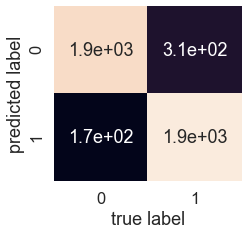

In [362]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, cat_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, cat_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, cat_pred)
print(confusion_matrix(y_test, cat_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 314 occasaions where the model predicted 0 when it should've been 1 (false negative) and 170 occasions where the model predicted 1 instead of 0 (false positive).

### 5.5.2 ROC Curve and AUC Scores for the CatBoostClassifier Model

<a id="neighbors"></a>

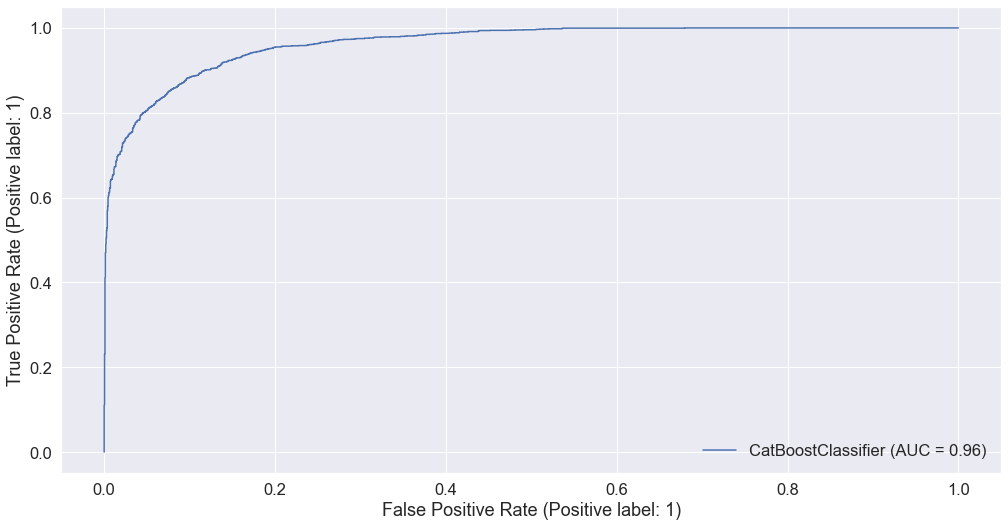

In [363]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(cat, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.96. But a perfect model would achieve an AUC score of 1.0.

### 5.6 XGBoost

<a id="xgb"></a>

In [364]:
np. random.seed(42)

# Instantiate the model
xg = XGBClassifier()

# Fit the model to the training data
xg.fit(X_train, y_train)

# Score the model on the test data
xg.score(X_test, y_test)

[09:48:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8957268927078496

In [365]:
# Make predictions on the model
xg_pred = xg.predict(X_test)
xg_pred[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1])

In [366]:
y_test[:10]

423      0
3522     0
15068    1
20594    1
4351     0
3002     0
9841     0
2830     0
14825    1
16762    1
Name: target, dtype: int32

In [367]:
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2188
           1       0.87      0.92      0.90      2118

    accuracy                           0.90      4306
   macro avg       0.90      0.90      0.90      4306
weighted avg       0.90      0.90      0.90      4306



In [368]:
print('Precision Score:', round(precision_score(y_test, xg_pred), 2))
print('Recall Score:', round(recall_score(y_test, xg_pred), 2))
print('F1 Score:', round(f1_score(y_test, xg_pred), 2))
print('Accuracy Score:', round(accuracy_score(y_test, xg_pred), 2))
print('ROC AUC: ', round(roc_auc_score(y_test, xg_pred), 2))

Precision Score: 0.87
Recall Score: 0.92
F1 Score: 0.9
Accuracy Score: 0.9
ROC AUC:  0.9


### 5.6.1 Confusion Matrix of XGBClassifier Model

<a id="neighbors"></a>

[[1899  289]
 [ 160 1958]]


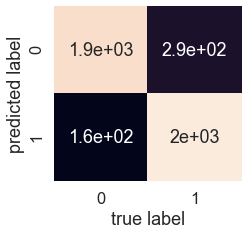

In [369]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, xg_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, xg_pred),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, xg_pred)
print(confusion_matrix(y_test, xg_pred))

You can see the model gets confused (predicts the wrong label). In essence, there are 289 occasaions where the model predicted 0 when it should've been 1 (false negative) and 160 occasions where the model predicted 1 instead of 0 (false positive).

### 5.6.2 ROC Curve and AUC Scores for the XGBClassifier Model

<a id="neighbors"></a>

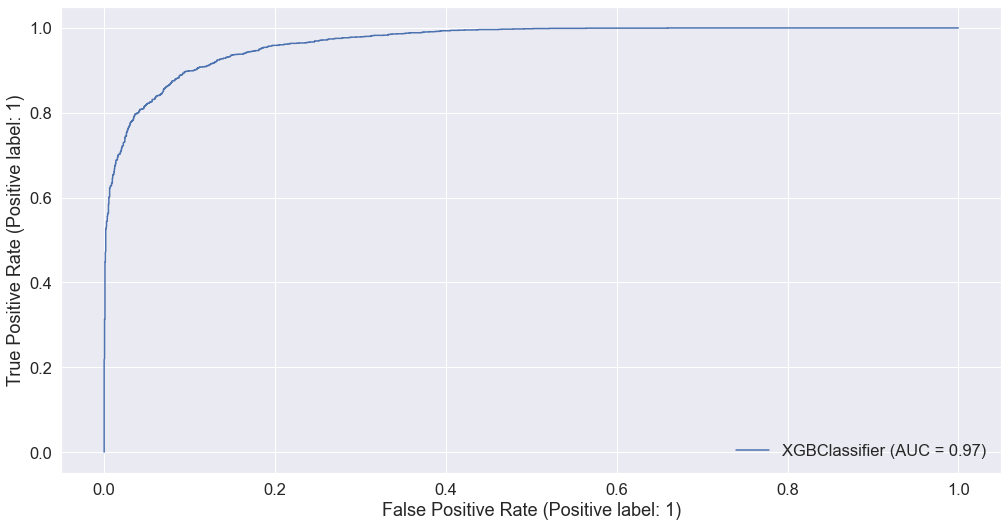

In [370]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(xg, X_test, y_test);

This is great, the model does far better than guessing which would be a line going from the bottom left corner to the top right corner, AUC = 0.97. But a perfect model would achieve an AUC score of 1.0.

### Train on full dataset

In [371]:
# Instantiating the random forest model on the full test dataset
rf.fit(X, y)

RandomForestClassifier()

In [372]:
y_pred = rf.predict(test_n)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<AxesSubplot:ylabel='count'>

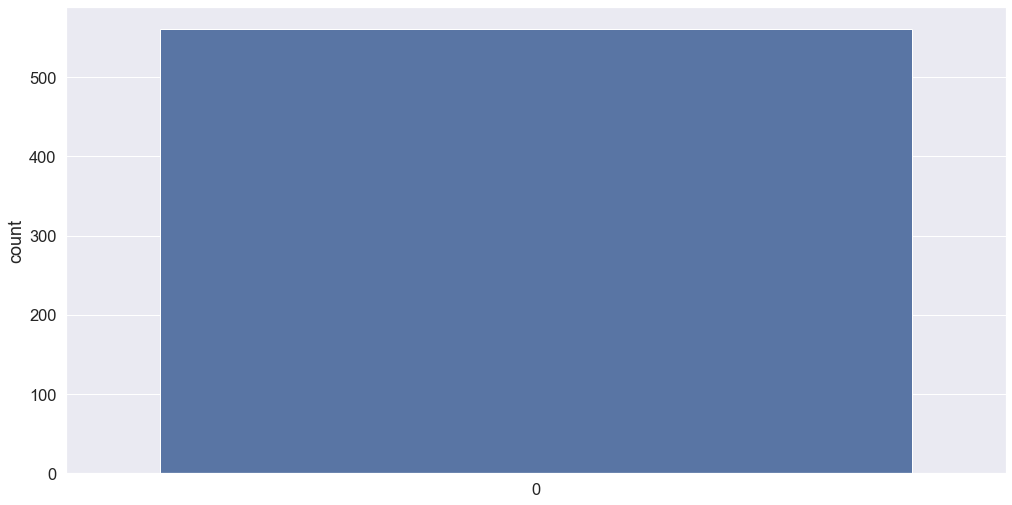

In [373]:
sns.countplot(y_pred)

In [374]:
set(test.ID==ss.ID)

{True}

In [2809]:
ss.head()

ID  target
0  ID_01QM0NU       0
1  ID_024NJLZ       0
2  ID_02NOVWQ       0
3  ID_02VSP68       0
4  ID_02YB37K       0

In [2810]:
sub_file = ss.copy()

In [2811]:
sub_file.target = prediction

In [2812]:
sub_file.head()

ID  target
0  ID_01QM0NU       0
1  ID_024NJLZ       0
2  ID_02NOVWQ       0
3  ID_02VSP68       0
4  ID_02YB37K       0

In [2813]:
sub_file.to_csv('base_model_pred_model.csv', index=False)

##  **6. Conclusion**

<a id="conclusion"></a>

<p style="text-align:center;">Given its high scores across the board, Random forest classifier performed slightly better than all the other machine learning models. With a high precision, recall and F1 score. This random forest model should be quite reliable at predicting which customers will claim insurance within the first 3 months.</p>

### Thanks for viewing this Notebook.